# NMF and CryptoPunks - a Great Reconstruction

Non-negative Matrix factorization, also called NMF, is a dimensionality reduction method that is able to transform high-dimensional data to low-dimensional data. It is a useful method to implement when wanting to either reduce the size of a dataset or wanting to retrieve the most general information from a dataset. This project takes a closer look into how the NMF works and how it applies to image datasets.
 
For our NMF to work we need to have a non-negative matrix. This matrix, A, with dimentions $mxn$, contains our original data. The matrix is further factorized into two matrices, W and H. These matrices will have dimensions respectively $mxd$ and $dxn$. Our value for d relates to the model complexity of the NMF and depending on what value we choose for d our results will vary. We obtain more information about A for larger values of d, but depending on the matrix this will either be beneficial or not. The algorithm will either way try to generalize and extract important structures from A. It collects the data in both $W$ and $H$ in such a way that $WH$ will become our reconstruction of A. The reconstruction will obtain less amount of data but hopefully yield a close approximation to our original matrix. 
 
We will apply the NMF to a set of images called CryptoPunks, and since images are non-negative the method will suffice. CryptoPunks is a set of 10,000 unique 24x24 pixels characters featuring different elements such as hats, cigars, sunglasses etc. Many of the features are shared by several characters. The portraits are RGBA images which means they have three color channels, red, green, and blue, and one channel for opacity. The linear combination of these will represent each pixel. In digital image processing, which we will dig into here, each color channel will hold a value between 0 and 1. The opacity channel will in our case have a set value that’s either 0 or 1.
 
Lastly, we will investigate noise and see how NMF operates on an image with unwanted modifications. We’ll come to learn that for certain input values the NMF will reduce the noise and increase the quality of the image. But as the model complexity of the NMF increases we can see that the noise will not disappear. We want to select a model complexity that avoids underfitting and overfitting, which we’ll get into later.
 
In order for us to discuss the method, optimize it and compare the different results we introduce the Frobenius norm. With this norm we can compare distances between matrices, which we consider the error. This norm is not a perfect description for what a human may consider the difference between images, but are only comparing the pixel values. It will still give us a good enough basis so that we will be able to compare the images. When we further on use the word "norm", we refer to the Frobenius norm. 


In [296]:
#importing libraries
import numpy as np
import matplotlib.pyplot as plt
#%pip install opencv-python # Required to import cv2 !!!
import cv2
#%pip install tabulate  
from tabulate import tabulate
import os
import time

## Properties of the algorithm

Before we implement the NMF-algorithm there are a few thing we need to check. 

#### $W_k$ and $H_k$ are always non-negative

As the name implies, Non-negative Matrix Factorization, the NMF method is based on finding


$\min_{W, H} \lVert{A-WH}\rVert_F , W, H non-negative $<br>

where 

$\lVert{A-WH}\rVert_F \hspace{3cm}(1) $ 

is the frobenius norm <br>

We will now see that if $W_0$ and $H_0$ are non-negative, all iterations of $W_{k}, H_{k}$ will be non-negative, so that the NMF method is valid. <br>

Assume that A is non-negative and that $W$ and $H$ are initialized as positive.
Show that all iterates $W_k$ and $H_k $ are non-negative. <br>

$H_{k+1} = H_k \odot   \frac{W_k^TA}{(W_k^TW_kH_k+\delta)}$ <br>

All elements in $H_k$ and $W_k>0 \Leftrightarrow$ all elements in $H_k^T$ and $W_k^T >0$, <br>

because transposing a matrix does not change any values in the matrix, only their positions.<br>
The multiplication in the numinator $W_k^TA$ thus gives a resulting matrix with all elements $>0$. <br>

We multiply column j in $W_k$ with row j in A, column by column and row by row, then we sum the products. In other words, we factorize positive numbers with each other, and then take the sum. The resulting matrix must therefore be a matrix with all elements $>0$. <br>

The same proof applies to the denominator in the fraction. <br>

All elements in $W_k^T, W_k, H_k >0\Rightarrow$ all elements in $W_k^TW_kH_k>0$ <br>

The next operations are elementwisely dividing and multiplying matrices with all elements $>0$, which will give a resulting matrix with all elements $>0$.<br>

If we assume that $W_0$, $H_0$ are non zero, then this implies that $W_1$ and $H_1$ must be non negative. 
The same applies for $W_k, H_k$. If they are non negative, then $W_{k+1}, H_{k+1}$ must be non negative, given the proof above. This proves that all iterates $W_k$ and $H_k $ are non-negative.



#### $WH = A$ when the algorithm converges

 
$c$ is a fixed point of a function $f$ if $f(c) = c$. <br>

This means that if $H_{k+1}(H_k) = H_k$, then $H_k$ is a fixed point.
 
Assume that $(W^T A) ⊘ (W^T W H)$ is a matrix of ones. We name this matrix $J$.
Then $H_{k+1} = H_k \odot    \frac{W_k^TA}{(W_k^TW_kH_k)} = H_k \odot J$  This means that we elementwisely multiply the elements in $H_k$ with 1. We will then get $H_k$.
 
$H_1 = H_0 \odot(W_0^T A) ⊘ (W_0^T W_0 H_0)$ <br>

Assume that $H_1 = H_0$<br>

$H_1= H_0 \odot(W_0^T A) ⊘ (W_0^T A) = H_0$
 
$\Rightarrow (W_0^T A) ⊘ (W_0^T W_0 H_0) = 1 \Rightarrow W_0^T A = W_0^T W_0 H_0 \Rightarrow W_0H_0 = A$
 
We will now prove that this applies for all $k>1$. <br>

Assume that $H_{k+1} = H_k$.
$H_{k+1} = H_k \odot    \frac{W_k^TA}{(W_k^TW_kH_k)} = H_k \Rightarrow \frac{W_k^TA}{(W_k^TW_kH_k)} = 1 \Rightarrow W_k^TA =W_k^TW_kH_k \Rightarrow A = W_kH_k$
 
We have now proved that $H_{k+1} = H_k$ if $(W^T A) ⊘ (W^T W H)$ is a matrix of ones, which means that $W_kH_k=A$. Since $H_{k+1}(H_k) = H_k$, this means that $H_k$ is a fixed point. This means that for the next iterations, our solution will not change. This agrees well with the fact that the solution gives two matrices $H_k$ and $W_k$ which multiplied gives the matrix A, which is what we want from our algorithm. 


$\lVert {A-W_{k+1} H_{k+1}}\rVert_F$ $\leq$ $\lVert {A-W_kH_k} \rVert_F \hspace{3cm}(2)$

#### Are there any difficulties with setting the initializations H0 and W0 equal to matrices containing only zeros?
 
The problem would be that we would get a division by zero error, because we have the multiplication of $W^T$ $W$ $H$ in the denominator. This problem we can solve by adding an infinitisimal number $\delta$ to our denominator. 
 
Now, we do not have a problem with division by zero. Nevertheless, our solution would simply be matrices of zeros, which is a non trivial solution to our problem. 
 
Therefore, we cannot set the initial matrices to only contain zeros.



## Investigation of four matrices

Before we start investigation of real images, we want to try the algorithm on smaller matrices. Therefore we start to investigate four small matrices A1, A2, A3 and A4. This will be a great way to see how the NMF is affecting the matrices, and confirm that the algorithm is working properly.  

In [301]:
#The four matrices A1, A2, A3, A4 we will be investigating in this task
A1 = np.array([[1, 0],[0, 1]])
A2 = np.array([[1, 2],[1, 1],[1, 2]])
A3 = np.array([[2, 1, 1],[2, 1, 1],[1, 1, 2]])
A4 = np.array([[2, 1, 0],[1, 2, 3],[0, 3, 3]])

print(tabulate(A1, tablefmt="fancy_grid"), end = " ")
print("A1")
print(tabulate(A2, tablefmt="fancy_grid"), end = " ")
print("A2")
print(tabulate(A3, tablefmt="fancy_grid"), end = " ")
print("A3")
print(tabulate(A4, tablefmt="fancy_grid"), end = " ")
print("A4")

╒═══╤═══╕
│ 1 │ 0 │
├───┼───┤
│ 0 │ 1 │
╘═══╧═══╛ A1
╒═══╤═══╕
│ 1 │ 2 │
├───┼───┤
│ 1 │ 1 │
├───┼───┤
│ 1 │ 2 │
╘═══╧═══╛ A2
╒═══╤═══╤═══╕
│ 2 │ 1 │ 1 │
├───┼───┼───┤
│ 2 │ 1 │ 1 │
├───┼───┼───┤
│ 1 │ 1 │ 2 │
╘═══╧═══╧═══╛ A3
╒═══╤═══╤═══╕
│ 2 │ 1 │ 0 │
├───┼───┼───┤
│ 1 │ 2 │ 3 │
├───┼───┼───┤
│ 0 │ 3 │ 3 │
╘═══╧═══╧═══╛ A4


## NMF-algoritmen 

Its now time to implement the NMF-algorithm: 

In [670]:
#NMF Algorithm 1
def WH_NMF(A, d, δ = 10**-9, maxiter= 1000, seed = 0):
    '''Input: m × n matrix A, number of components d, safe division constant δ and
    maximum iterations maxiter.
    Output: Approximate NMF factorization W and H so that ANMF = W H'''
   
    #A: mxn
    #W: mxd
    #H: dxn
    
    #We want a seed so that we get the same values each time. This makes it easier to find errors in our code. 
    if seed != 0:  #If we want a new randome value
        np.random.seed(seed)
        
    m, n = np.shape(A) #Finding the shape of A
    W0 = np.random.uniform(0, 1, (m*d)) #Give the start value of W randome numbers, and shape mxd
    H0 = np.random.uniform(0, 1, (d*n)) #Give the start value of H randome numbers, and shape dxn
    W = np.reshape(W0* np.sqrt(np.mean(A)/d), (m,d)) #
    H = np.reshape(H0*np.sqrt(np.mean(A)/d), (d,n))
  
    normen = np.zeros(maxiter) #Array so we can save the norm for each iteration

    for k in range(maxiter):

        H = np.multiply(H, (np.divide(np.dot(W.T, A), np.dot(np.dot(W.T, W), H)+δ))) #Updating the values for H
        W = np.multiply(W, (np.divide(np.dot(A, H.T), np.dot(np.dot(W, H), H.T)+δ))) #Updating the values for W

        normen[k] = np.linalg.norm(A - np.dot(W,H), 'fro')
    return W, H, normen

δ = 1e-9 #Adding this value so we never get zero in the matrices

W1, H1, norm1 = WH_NMF(A1, 1, δ, 1000) #NMF for A1
W2, H2, norm2 = WH_NMF(A2, 1, δ, 1000) #NMF for A2
W3, H3, norm3 = WH_NMF(A3, 1, δ, 1000)  #NMF for A3
W4, H4, norm4 = WH_NMF(A4, 1, δ, 1000)  #NMF for A4
W1_1, H1_1, norm1_1 = WH_NMF(A1, 1, δ, 1000, 1)  #NMF for A1 with new seed 
W2_1, H2_1, norm2_1 = WH_NMF(A2, 1, δ, 1000, 1)  #NMF for A2 with new seed
W3_1, H3_1, norm3_1 = WH_NMF(A3, 1, δ, 1000, 1)   #NMF for A3 with new seed
W4_1, H4_1, norm4_1 = WH_NMF(A4, 1, δ, 1000, 1)   #NMF for A4 with new seed

### A1 and A2 

#### d = 1

To start off we would like to try the algorithm on A1 and A2. First we use d = 1 and two different random initializations. We want to compare both W and H for the two different initializations and for both matrices. We also want to see how the reconstructions WH vary, and the $\lVert{A-WH}\rVert_F$. We use 1000 iterations to ensure that the algorithm has converged. 

In [671]:
#printing the tabular in 1d

print('A1:\n')
print('We print the values for our first random initialization')
print(tabulate(W1, tablefmt="fancy_grid"), end = " ")
print('W in matrix A1')
print(tabulate(H1, tablefmt="fancy_grid"), end = " ")
print('H in matrix A1')
print(tabulate(np.dot(W1, H1), tablefmt="fancy_grid"), end = " ")
print('WH in matrix A1')
print('The norm corresponding to Matrix A1 is ', norm1[-1], '\n\n')
print('We now print the values for our second random initialization')
print(tabulate(W1_1, tablefmt="fancy_grid"), end = " ")
print('W in matrix A1 with another seed')
print(tabulate(H1_1, tablefmt="fancy_grid"), end = " ")
print('H in matrix A1 with another seed')
print(tabulate(np.dot(W1_1, H1_1), tablefmt="fancy_grid"), end = " ")
print('WH in matrix A1 with another seed')
print('The norm corresponding to Matrix A1 with another seed is ', norm1_1[-1], '\n\n\n')
print('A2:\n')
print('We print the values for our first random initialization')
print(tabulate(W2, tablefmt="fancy_grid"), end = " ")
print('W in matrix A2')
print(tabulate(H2, tablefmt="fancy_grid"), end = " ")
print('H in matrix A2')
print(tabulate(np.dot(W2, H2), tablefmt="fancy_grid"), end = " ")
print('WH in matrix A2')
print('The norm corresponding to matrix A2 is ', norm2[-1], '\n\n')
print('We now print the values for our second random initialization')
print(tabulate(W2_1, tablefmt="fancy_grid"), end = " ")
print('W in matrix A2 with another seed')
print(tabulate(H2_1, tablefmt="fancy_grid"), end = " ")
print('H in matrix A2 with another seed')
print(tabulate(np.dot(W2_1, H2_1), tablefmt="fancy_grid"), end = " ")
print('WH in matrix A2 with another seed')
print('The norm corresponding to matrix A2 with another seed is ', norm2_1[-1], '\n\n')


A1:

We print the values for our first random initialization
╒══════════╕
│ 0.131706 │
├──────────┤
│ 0.24435  │
╘══════════╛ W in matrix A1
╒═════════╤═════════╕
│ 1.70929 │ 3.17118 │
╘═════════╧═════════╛ H in matrix A1
╒══════════╤══════════╕
│ 0.225123 │ 0.417664 │
├──────────┼──────────┤
│ 0.417664 │ 0.774877 │
╘══════════╧══════════╛ WH in matrix A1
The norm corresponding to Matrix A1 is  1.0 


We now print the values for our second random initialization
╒══════════╕
│ 0.294874 │
├──────────┤
│ 0.509356 │
╘══════════╛ W in matrix A1 with another seed
╒══════════╤═════════╕
│ 0.851266 │ 1.47045 │
╘══════════╧═════════╛ H in matrix A1 with another seed
╒══════════╤══════════╕
│ 0.251016 │ 0.433598 │
├──────────┼──────────┤
│ 0.433598 │ 0.748984 │
╘══════════╧══════════╛ WH in matrix A1 with another seed
The norm corresponding to Matrix A1 with another seed is  1.0 



A2:

We print the values for our first random initialization
╒══════════╕
│ 0.756661 │
├──────────┤
│ 0.461804 │
├


We see that W and H for A1 are very different with different seeds. The reconstruction of the matrix WH is also different for the two seeds.  Neither of them are good reconstructions of A1, which we also can see from the Frobenious norm, which is 1. It turns out that for all different initialistations of W and H, the frobenius norm of A1 (reconstruted) will always be 1. This is because it impossible to reconstruct the 2x2 identity matrix with a 2x1 and a 1x2 matrix. 

The case is pretty similar for A2. Different seeds give different W and H. But compared to A1, the reconstruction of WH will be identical for A2 independent of which seeds we use. This could be because the original matrix A2 consists of different singular values, while A1 has identical eigenvalues (which we will come back to). We can also see that the fronbenious norm is a unique quantity for both A1 and A2. This could be a good sign that the method is working, and the error does not depend much on the random initialization we give $W_0$ and $H_0$. 


#### d = 2

We know want to see what happens if we increase the value of d to d = 2. 

In [363]:
# d = 2: 
W1d2, H1d2, norm1d2 = WH_NMF(A1, 2, δ, 10000, 4) #NMF for A1
W2d2, H2d2, norm2d2 = WH_NMF(A2, 2, δ, 10000, 4) #NMF for A2
print('Norm A1 (med d=2): ', norm1d2[-1])
print('Norm A2 (med d=2): ', norm2d2[-1])

Norm A1 (med d=2):  1.0938838924060359e-09
Norm A2 (med d=2):  1.4033572489891929e-09


As we can see $\lVert{A-WH}\rVert_F \approx 0$ for both matrices. This means that the reconstructions of the matrices are much better for d=2, than d=1. It will be easier to explain this if we first take a closer look into the rank of the matrices. <br>

The definition of a rank is the subspace spanned by its rows. The rank of a mxn matrix is never bigger than the smallest of m and n. In addition we have to subtract the dimension of the eigenspace corresponding to zero. The number of eigenvalues that are diffenet from zero will decide the rank of the matrix. We use the numpy build-in-function: "np.linalg.svd" to calculate the ranks of the four matrices.




In [665]:
def findRank(A1, name):
    u_A1, s_A1, vh_A1 = np.linalg.svd(A1)
    Svdlist_A1 = np.where(s_A1>10**-12) #finding positions where components are bigger than zero (or a limit)
    print("Rank of", name, "is", len(Svdlist_A1[0]))

findRank(A1, 'A1')
findRank(A2, 'A2')

Rank of A1 is 2
Rank of A2 is 2



The rank of both A1 and A2 are 2. Now we can see that our results are reasonable. We expected the error to decrease as we increased d, at least up to the rank of the matrix. It is difficult to say whether or not the NMF is able to capture all the non-negative features of a matrix, and for which values of d the frobenius norm is smallest. 

Another interesting thing to look into is how many iterations we need to such a small norm. 



### Different initializations

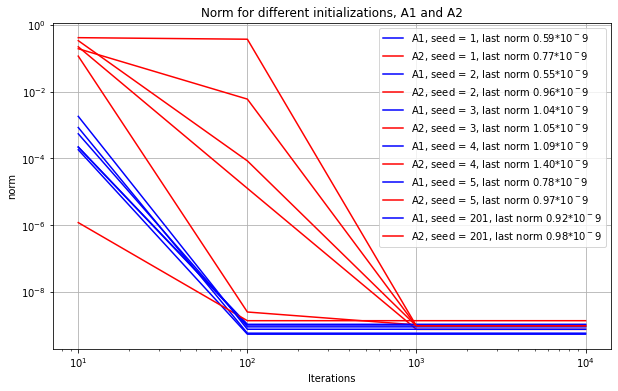

In [615]:
#Different seeds to get different values.
seedArr = np.array([1, 2, 3, 4, 5, 201])   
for i in range(len(seedArr)):
    runtime = np.array([10, 100, 1000, 2000, 5000, 10000]) #number of iterations
    normArr1 = np.zeros(len(runtime)) 
    normArr2 = np.zeros(len(runtime))
    for j in range(len(runtime)):
        W1, H1, norm1 = WH_NMF(A1, 2, 1e-9, runtime[j], seedArr[i]) #calculating norm for different seeds A1
        W2, H2, norm2 = WH_NMF(A2, 2, 1e-9, runtime[j], seedArr[i]) #calculating norm for different seeds A2
        normArr1[j] = norm1[-1] #using the las value
        normArr2[j] = norm2[-1]
    plt.figure(1, (10, 6))
    plt.xlabel('Iterations')
    plt.ylabel('norm')
    plt.title('Norm for different initializations, A1 and A2')
    plt.loglog(runtime, normArr1, label = "A1, seed = {0}, last norm {1:.2f}*$10^-9$".format(seedArr[i], normArr1[-1]/1e-9), color = 'b')
    plt.loglog(runtime, normArr2, label = "A2, seed = {0}, last norm {1:.2f}*$10^-9$".format(seedArr[i], normArr2[-1]/1e-9), color = 'r')
plt.legend()
plt.grid()
plt.show()

We have run the NMF fit on both $A_1$ and $A_2$ with d=2. The rank of these matrices is also 2 $\Rightarrow d=2=rank \Rightarrow$ this should be a good value for d. We see that both $A_{1NMF}$ and $A_{2NMF}$ converge to $A_1$ and $A_2$. 
 
What is also interesting is that $A_1$ converges after $10^2$ iterations, while $A_2$ converges after $10^3$ iterations. $A_2$ has much more variation in norm for different seeds before converging. This could be because W and H that reproduce A1 only have elements on the diogonal, and therefore there will be less possible combinations of W and H. While W and H for A2 have all the elements different. This means there are more combinations of W and H that will reproduce A2. In this way we would asume the algorithm could much easier get stuck at a local minimizer (espesially for few iterations). An example is the top red line, witch does not decrease at all between 0 and 100 iterations. It would be reasonable to think that it is stuck at a local minimizer. 
 
 
We also see that different seeds give very different resulting matrices if we have fewer than $10^3$ iterations for A2. The same applies to $A_1$ but to a lower extent. This is because $A_2$ is of greater dimension than $A_1$, ie $W$ and $H$ will try to store more information than for $A_1$. It is therefore more time consuming to find a $A_{NMF}$.
 
This is probably not very interesting for matrices with such low dimensions, but we will later see that the same results and logic also applies for bigger matrices. 

For d=2=rank to both of the matrices, we see that the norm converges to $\delta$. Is this random? Or is there a reason behind it? We need to take a closer look at this. 


### $ \lVert{A-WH}\rVert_F$ compared to $\delta$

We plot the frobenius norm for different values of $\delta$ with logarithmic axes

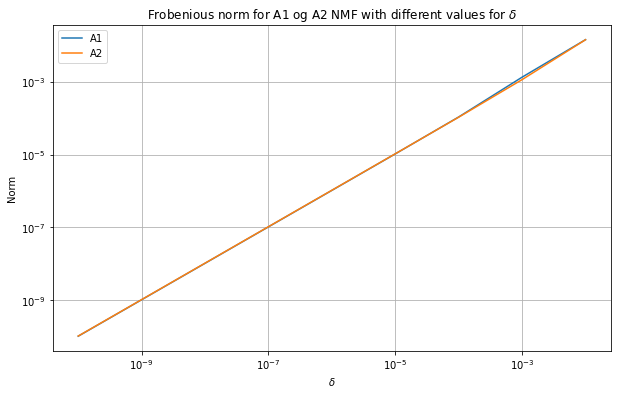

In [343]:
#Norm(delta)
delta = np.array([1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]) #different values for delta
def normDelta(A, delta, d):
    normArr = np.zeros(len(delta))
    for i in range(len(delta)):
        W, H, norm = WH_NMF(A, d, delta[i], 1000, 3) #calculating the norm from NMF
        normArr[i] = norm[-1]
    return normArr


plt.figure(2, (10, 6))
plt.loglog(delta, normDelta(A1, delta, 2), label = 'A1')
plt.loglog(delta, normDelta(A2, delta, 2), label = 'A2')
plt.legend()
plt.title('Frobenious norm for A1 og A2 NMF with different values for $\delta$')
plt.xlabel('$\delta$')
plt.ylabel('Norm')
plt.grid()
#Normen er logaritmisk lineær med delta.

We see that there is an obvious connection between $\delta$ and the norm. It looks like the norm is approximately equal to $\delta$ for both the matrices. We try to look into how we can explain this. 

We know that <br>
$(1) H_{k+1} = H_k\odot \frac{W_k^TA}{W_k^TW_kH_k + \delta}$ <br>
$(2) W_{k+1} = W_k\odot \frac{A H_{k+1}^T}{W_kH_{k+1}H_{k+1}^T + \delta}$ <br>
Since we have used 10000 iterations we can assume that we have reached convergence, therefore we can simplify $W_{k+1} \approx W_k$, $H_{k+1} \approx H_k$. <br>

We first take a look at (2) <br>

$(2)$: since $\odot$ and $\oslash$ is elementwisely multiplication and division, we can factorize by $W_{k+1} \approx W_k$, and get the unit matrix: <br>
$(2) I = I \odot\frac{A H_{k+1}^T}{W_kH_{k+1}H_{k+1}^T + \delta}$
$\Rightarrow W_k H_{k+1} H_{k+1}^T + \delta = A H_{k+1}^T$
$\Rightarrow \delta = A H_{k+1}^T - W_k H_{k+1} H_{k+1}^T $ <br>

We can factorize the matrix $H_{k+1}^T$.
$\Rightarrow \delta = (A  - W_k H_{k+1}) H_{k+1}^T $
 
Now we take the Frobenious norm on each side. <br>

$\lVert\delta\rVert_F = \delta$ <br>
$\delta = \lVert(A  - W_k H_{k+1}) H_{k+1}^T\rVert_F$ <br>

The same applies to equation (1). <br>
This gives:<br>

$\delta = \lVert W_{k+1}(A  - W_k H_{k+1})\rVert_F$<br>

Now, we will take a closer look at how SVD can help explain how our norm converges to $\delta$.
We know that a reduced SVD can be factorized on the form:<br>

$ A \approx U_d \sum_d V_d^T$ <br>

We know that if A has only d (in this case two) non-zero singular values, or d eigenvalues if A is normal then <br>

$ A = U_d \sum_d V_d^T \hspace{3cm} (3)$<br> 

where U and V are unitary matrices. <br>

We know that A2 is not normal (not square), but it has two non-zero singular values, and is therefore (3) applies. 

We need to check if A1 is normal. A is normal if

$A_T A = A A_T$ <br>

is satisfied. 




In [350]:
print(np.dot(A1.T, A1) == np.dot(A1, A1.T))

[[ True  True]
 [ True  True]]


We see that A1 is normal and know from earlier that it has two eigenvalues (rank two). Therefore we know that (3) is also satisfied for A1. <br>

When W and H have converged, we have $A \approx WH$.<br> 
If we put this together with (3) we get <br>
$WH \approx U_d \sum_d V_d^T$ <br>

Then we can say that for example that $W=U_d$ and $H=\sum_d V_d^T$ or $W=U_d\sum_d$ and $H=V_d$<br>

Since we know that both $U_d$ and $V_d$ are unitary, we can now say that H and W also are unitary. <br>

We also know that for the frobenius norm the following applies: <br>
$\lVert AU \rVert_F = \lVert UA \rVert_F= \lVert A \rVert_F$ <br>
for an unitary matrix U. <br>

$\Rightarrow \delta = \lVert W_{k+1}(A  - W_k H_{k+1})\rVert_F = \lVert (A  - W_k H_k\rVert_F$ <br>
which we see in our runs. 


This is only an idea we wanted to investigate, and we cant say for sure that this is valid. We wont go into it further. Let's return to our NMF!


### A3 and A4

We have studied A1 and A2 in detail, but now it is time to move on to A3 and A4. First we calcuate the rank: 

In [360]:
findRank(A3, 'A3')
findRank(A4, 'A4')

Rank of A3 2
Rank of A4 3


Rank of $A_3=2$ and rank of $A_4=3$. Even though both matrices have dimension $3x3$, $A_3$ only has $rank=2$, which means that only 2 out of the three columns are linearly independent. As we saw for A1 and A2 the norm decreased with an increase of d, at least up to the rank. We will confirm that this is the case for A3 and A4 as well. 

We run the NMF algorithm on $A_3$ and $A_4$ for different values of d; $d=1, d=2, d=3$, and plot the Frobenious norm as a function of number of iterations in two separate plots. 


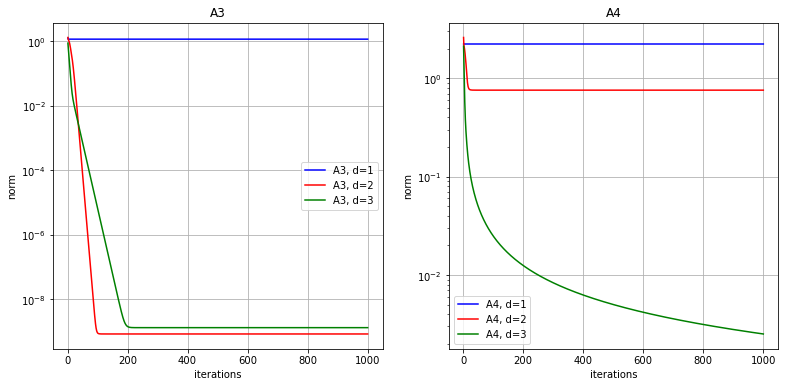

In [475]:
#Fitting NMF for A3 and A4 with d = 1,2 and 3
W3d1, H3d1, norm3d1 = WH_NMF(A3, 1)
W4d1, H4d1, norm4d1 = WH_NMF(A4, 1)
W3d2, H3d2, norm3d2 = WH_NMF(A3, 2)
W4d2, H4d2, norm4d2 = WH_NMF(A4, 2)
W3d3, H3d3, norm3d3 = WH_NMF(A3, 3)
W4d3, H4d3, norm4d3 = WH_NMF(A4, 3)

maxiter = np.linspace(1, 1000, 1000) #array with number of iteration

#plotting:
fig, axs = plt.subplots(ncols = 2, sharex = False)
fig.set_size_inches(13, 6)
axs[0].plot(maxiter, norm3d1, label = 'A3, d=1', color = 'b')
axs[1].plot(maxiter, norm4d1, label = 'A4, d=1', color = 'b')
axs[0].plot(maxiter, norm3d2, label = 'A3, d=2', color = 'r')
axs[1].plot(maxiter, norm4d2, label = 'A4, d=2', color = 'r')
axs[0].plot(maxiter, norm3d3, label = 'A3, d=3', color = 'g')
axs[1].plot(maxiter, norm4d3, label = 'A4, d=3', color = 'g')
axs[0].legend()
axs[1].legend()
axs[0].grid()
axs[1].grid()
axs[0].set_yscale('log')
axs[0].title.set_text('A3')
axs[1].title.set_text('A4')
axs[1].set_yscale('log')
axs[0].set_ylabel('norm')
axs[0].set_xlabel('iterations')
axs[1].set_ylabel('norm')
axs[1].set_xlabel('iterations')
plt.show()

Equation (2) implies that the norm decreases for every iteration through the NMF algorithm. If the slope numbers in our graphs are negative or constant, the equation is satisfied. We can see that this is the case. 

Firstly we will take a look at $A_3$. From earlier we know that the rank is two. As we can see from the plot, $d=2$ gives the lowest norm, and the norm is very low even for a small number of iterations. As mentioned earlier, we can only know for sure that the frobenius norm to the NMF decreases up to d=rank. If we increase d further after the rank, we cannot know for sure whether or not the approximation will get better or worse. In our case ($A_3$) an increation of d, to d=3, made a bigger error, and the frobenius norm converged slower. It is as expected that bigger matrices use more time to converge as mentioned earlier. d=1 converges really fast, and is stuck at a local minimizer after just a few iterations.  

For A4, with rank = 3, we see that d = 3 is the best approximation. This is as expected. After 1000 iterations it still has not converged, and we don't know how many iterations it will need for this to happen. We can notice that d=rank is much better than d=1 or d=2.


## CryptoPunks 

We’re now going to look at the CryptoPunks introduced earlier. We load 500 of the 10.000 images to begin with. When we apply the NMF to an image we need to think about how we reshape the images and how we treat their opacity. Our matrix needs to be an $m \cdot n$ array, because this is what our NMF operates on. We solve this by reshaping the matrix both before and after applying the NMF. We solve the second problem by storing the opacity and adding it back onto the image after applying the NMF. Lastly we need to take into consideration that the NMF might give out values for our color channels that's larger than one, which we don't want. We have resolved this issue by setting these values to one. This won't give us a perfect reconstruction but still yield a picture we can interpret. 

The reason NMF works well on the CryptoPunks is because a lot of their features are both shared and centered. Certain accessories are quite common and will appear on several CryptoPunks. Likewise will the facial features be centered such that the CryptoPunks have eyes, mouth, nose etc. located at the same pixel. This makes the NMF able to both generalize what's consistent and extract the special features. 



In [247]:
def load_images(N):
    """
    Loads images from cryptopunk dataset. The loading order is deterministic,
    so for a certain N the exact same images will be loaded. 
    Input:
        N, integer, number of images to load
    Output:
        faces, (24,24,4,N) numpy array containing images
    """

    # Allocate array to store images
    faces = np.zeros((24,24,4,N))

    # Iteration variable
    i = 0

    # Iterate over folders
    for subdir, dirs, files in os.walk('./imgs'):

        # Iterate over files
        for file in files:

            # Filepath to load from
            filepath = subdir + os.sep + file

            # Make sure that the file is a .png
            if filepath[-3:] == 'png':

                # Load the image
                im = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)

                # Convert it to RGBA and rescale pixels
                faces[:,:,:,i] = cv2.cvtColor(im, cv2.COLOR_BGRA2RGBA)/255.0

                i+=1
            if i == N:
                break
    return faces

# Number of faces to keep in final array
N = 500

# Load all 10000 images
faces = load_images(500)

# Select N random images
choices = np.random.choice(faces.shape[-1],N, replace = False)
faces = faces[:,:,:,choices]



In [248]:
# Code for plotting images
def plotimgs(imgs, nplot = 8, rescale = False, filename = None, few = False):
    """
    Plots nplot*nplot images on an nplot x nplot grid. 
    Saves to given filename if filename is given
    Can also rescale the RGB channels 
    input:
        imgs: (24,24,4,N) or (24,24,3,N) array containing images, where N > nplot**2
        nplot: integer, nplot**2 images will be plotted
        rescale: bool
        filename: string, figure will be saved to this location. Should end with ".png".
    """
    # We will change some of the parameters of matplotlib, so we store the initial ones
    oldparams = plt.rcParams['figure.figsize']

    # New params to make better plot. There definitely exists better ways of doing this
    if few: 
        plt.rcParams['figure.figsize'] = (4, 4)
    else:     
        plt.rcParams['figure.figsize'] = (16, 16)

    # Initialize subplots
    fig, axes = plt.subplots(nplot,nplot)

    # Set background color
    plt.gcf().set_facecolor("lightgrey")

    # Iterate over images
    for idx in range(nplot**2):
        
        # Indices
        i = idx//nplot; j = idx%nplot

        # Remove axis
        axes[i,j].axis('off')

        # Rescale RGB channels by dividing my maximal value
        if rescale:
            scaled_img = np.copy(imgs[:,:,:,idx])
            scaled_img[:,:,:3] = scaled_img[:,:,:3]/np.max(scaled_img[:,:,:3])
            axes[i,j].imshow(scaled_img)
        else:
            axes[i,j].imshow(imgs[:,:,:,idx])
    
    # Tight layout so images will appear closer together
    plt.tight_layout()

    # Save if filename is given
    if filename is not None:
        plt.savefig(filename)

    plt.show()

    # Return to old parameters
    plt.rcParams['figure.figsize'] = oldparams


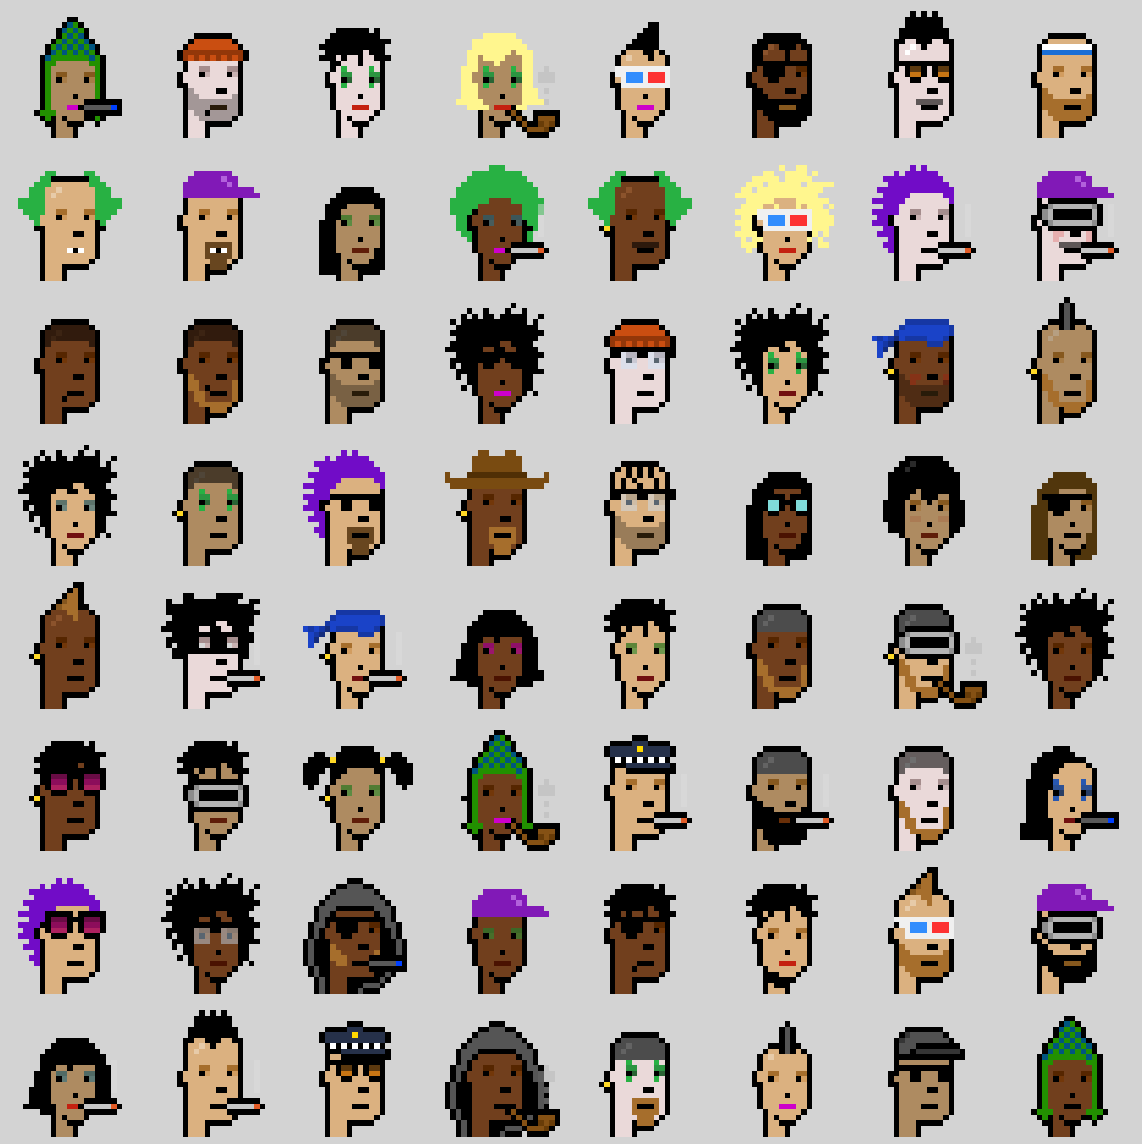

In [249]:
# Example of plotting 8 times 8 images stored in "faces" and saving the output to a file named "punks.png"
plotimgs(faces, 8, filename="punks.png")

We start by plotting 64 of the images on a 8 x 8 grid of subplots. As described earlier we can tell that certain features are both common and centered. But they do have different hairstyles, skin color and accessories than make none of them alike. Some features are even to be spotted twice or more which tells us that certain features probably are more common than others. We will now investigate further. 

### Mean cryptoPunk

It would be interesting to see an "average cryptoPunk face". We’ve plotted the mean of 500 CryptoPunks and under yields the result.  Since all the CryptoPunks’ critical features appear at the exact same pixels we obtain an image that we can recognize to be a CryptoPunk. These facial features are more or less not “disturbed” in the way that you can still recognize their shape and size. 

Text(0.5, 1.0, 'Mean cryptoPunk')

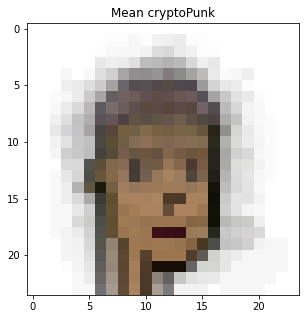

In [451]:
# Split the images into opacity and rgb channels
faces_opacity = faces[:,:,3,:]
faces_rgb = faces[:,:,:3,:]
shape = faces_rgb.shape

# Clever reshape "trick". This is the matrix we will apply the NMF to
faces_reshaped = faces_rgb.reshape(np.prod(shape)//N, N)

W, H, normen = WH_NMF(faces_reshaped, 64)  #Calculating the NMF of the 3 color channels using d = 64

mean = np.mean(faces, axis = 3) #find the mean cryptoPunk

#plotting it: 
plt.figure(figsize = (20,5))
plt.imshow(mean)
plt.title('Mean cryptoPunk')

Looking at the mean-CryptoPunk we can get to know more. One can also recognize some features that are less common. For example, a cigarette is to be observed in the lower right corner even though its pixels are fairly transparent as most CryptoPunks do not have one. Likewise does our man have a darker skin-color around his mouth which is likely due to beards on certain CryptoPunks. The same goes for his forehead, and is probably caused by hats and hair. By this “mean-figure” one can tell some about what features are common and recognize some of them.

There's in overall a huge variety in how strong the colors are. His lips are quite visible. His outline is also fairy colored, but we can see small nuances in the black shades. This can be explained by the different accessories the CryptoPunks inhabit. The cigarette mentioned above is for example a different color shade than black and it does cross the outline of their face. Therefore, the shades in most places will vary due to the accessories crossing even the common features (and different features in general). We also observe that most pixels with high opacity are closer to the center, which we also would expect.

We can actually use this "mean-image" to say something about the rank of the original faces-matrix. Since several of the CryptoPunks share the same features some of the columns of W will be linearly dependent. We also observe that numerous pixels on the mean image are white. This means the pixels have no opacity and the colorchanels are zero. This shows that these basis vectors are linearly dependent, meaning that the rank is lower than the maximum theoretical rank. The number of pixels that's occupied in our mean-CryptoPunk can be calculated, hence the function “findRank2”. 





In [452]:
#print(faces)
def findRank2(f):
    antall = 0
    for i in range(24):
        for j in range(24):
            if f[i][j][-1] > 0 : #if opacity is bigger than zero
                antall += 1
    return antall
print('Number of opaque pixels: ', findRank2(mean))

findRank(faces_reshaped, 'Faces using SVD: ')

Number of opaque pixels:  410
Rank of Faces using SVD:  385


There are a total of 410 opaque pixels. We would expect the maximum rank to be 410$\cdot$3 = 1230, considering all three color channels (and assuming that all of them contain non-negative values, which is not always the case). This means that the rest of the pixels are without opacity, and therefore will not contribute to increasing the rank. If all the pixels had opacity, the maximum theoretical rank would be $24\cdot 24 \cdot 3$ = 1728. Since we operate with 500 images its maximum rank is 500. 

To actually calculate the rank, we could use the rank-function we made for the smaller matrices. This will give us the svd-rank. We would expect this number to be smaller than 410. This is because we assumed that all the colored pixels were unique at first. But this may not be the case. If some of them are identical, the rank will decrease. We see that we get the value 385 for the svd rank. When we made the “findRank” function before, we also put in a very small limit, so that the values didn't have to be exactly zero. This means that if two colorchanels are really close to each other in value, they will be considered the same, and therefore linearly dependent. 

Now that we know the rank we can use that later on when we are comparing the norm for different values of d.


## Plotting W, the basis vectors

Next, we want to plot the W matrix that we attain after applying the NMF to the three color channels with a value of d equal to 64.



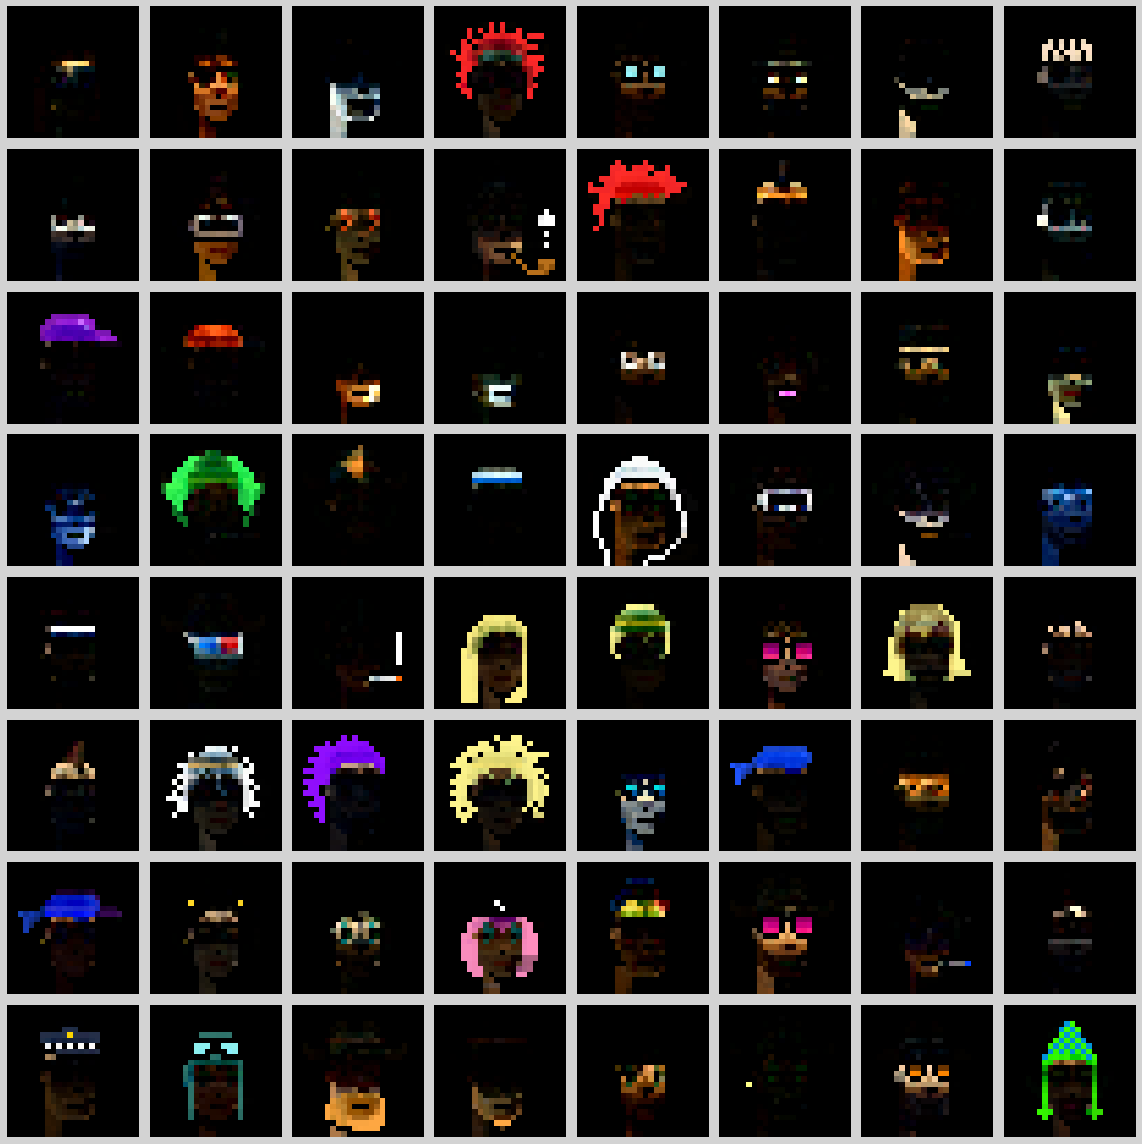

In [621]:
#Reshaping
WH = np.dot(W, H)
WH = WH.reshape(24, 24, 3, 500)  #Reshaping

W[W>1]=1  #Clipping pixel values that are larger than 1, by setting them to 1. 
H[H>1] = 1  #Clipping 
W = W.reshape(24,24,3,64)
plotimgs(W, nplot = 8, rescale = True, filename = "W") #Plotting columns of W

Here we have plotted the columns of W, which can be interpreted as approximate non-negative basis vectors for the faces-matrix. The images of W can be described as incomplete. Most of the images contain certain features, such as a hat or a hairstyle. Some frames are less easy to interpret. The W matrix is not quite comparable to the matrix WH. The features we observe in W will not correspond to the image in WH that's located in the same frame. That's because when we calculate the matrix product of W and H, and will combine several of the images alongside with the information in H. But we can recognize that the properties in W will appear in WH. For example can features such as pink sunglasses, a greenblue hat and big purple hair be observed both in the W and WH (faces-matrix). 

Also, the W column is lacking the opacity channel. We stored the channel before applying the NMF which means we now only have the 3 color channels represented. We do this as learning the opacity channel would reduce the quality of our reconstruction, so we add it back after the matrix multiplication. For our W, this means we can't separate the black pixels from our grey default background as the pixels now overlap this area. Certain details in our W are therefore harder to spot than they would be if the opacity channel were present. This specifically applies to the details that are black or on the darker 
scale.

Lastly, we observe that W not only holds one feature, but often pixels around it too. One can for several of the images vaguely see the outline of the CryptoPunks face and some of the facial features. For the cigarette that has been stored one can spot some pixels to have a brownish color where one would expect to find a mouth. Likewise do the hats also hold some information about the CryptoPunks eyes and forehead. This is because our algorithm recognizes a pattern where the accessories and some other features often appear together. It therefore saves the information together. In H we find the associated coefficients, ergo the weights of each feature. Together with W we will be able to reconstruct A. 

This plotting was done for d = 64, but what happens if we use a bigger or smaller value?

### Trying with different model complexity

In [427]:
#def differentD(d):

#fiting NMF using d=10
W_d10, H_d10, normen_d10 = WH_NMF(faces_reshaped, 10, δ = 10**-9, maxiter= 1000, seed =1)
W_d10 = W_d10.reshape(24,24,3, 10)
W_d10[W_d10>1]=1  #Clipping pixel values that are larger than 1, by setting them to 1. 

#fiting NMF using d=64 (as we have done before)
W_d64, H_d64, normen_d64 = WH_NMF(faces_reshaped, 64, δ = 10**-9, maxiter= 1000, seed =1)
W_d64 = W_d64.reshape(24,24,3, 64)
W_d64[W_d64>1]=1  #Clipping pixel values that are larger than 1, by setting them to 1. 

#fiting NMF using d=128
W_d128, H_d128, normen_d128 = WH_NMF(faces_reshaped, 128, δ = 10**-9, maxiter= 1000, seed =2)
W_d128 = W_d128.reshape(24,24,3, 128)
W_d128[W_d128>1]=1  #Clipping pixel values that are larger than 1, by setting them to 1. 


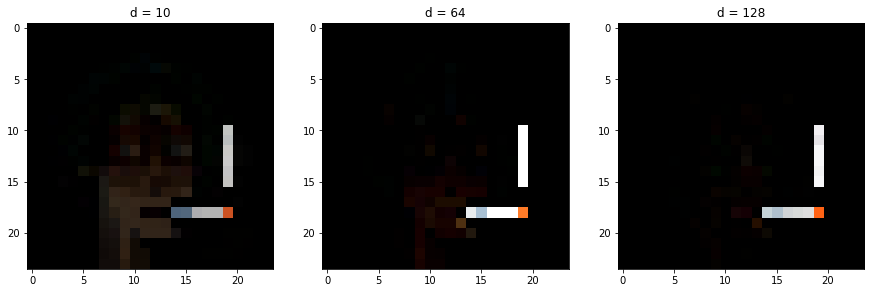

In [430]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_figheight(15)
fig.set_figwidth(15)
ax1.set_title("d = 10")
ax2.set_title("d = 64")
ax3.set_title("d = 128")
ax1.imshow(W_d10[:,:,:,2])
ax2.imshow(W_d64[:,:,:,63])
ax3.imshow(W_d128[:,:,:,86])
plt.show()

We have now been able to find the cigarette from each W (with different d). The image with d = 10 have many dark brown pixels, forming a facial structure, in addition to the cigarette itself. This is because with a lower model complexity each image has to hold more general information. As we increas d to 64, much of the brown pixels disappeared. And with d = 128 we can almost only see the cigarette in the image. This means that the matrix is big enough so that each image can contain more specific information, and the reconstruction will get even better.

### Reconstruction of the images

After applying the NMF and studying W we move on to plotting the reconstruction. After we multiply W and H, and put back the opacity, we get the images as following:

In [479]:
faces_opacity = faces_opacity.reshape(24, 24, 1, 500)  #To concatenate we need our arrays to have the same size, except the axis we will concatenate (axis = 2)
 
faces_reconstructed = np.concatenate((WH, faces_opacity), axis=2)   #Reconstructing our values by adding the opacity values as the last element behind our RGB values. This is the third axis (index 2) of our array. 

faces_reconstructed[faces_reconstructed>1]=1  #Clipping pixel values that are larger than 1, by setting them to 1. 

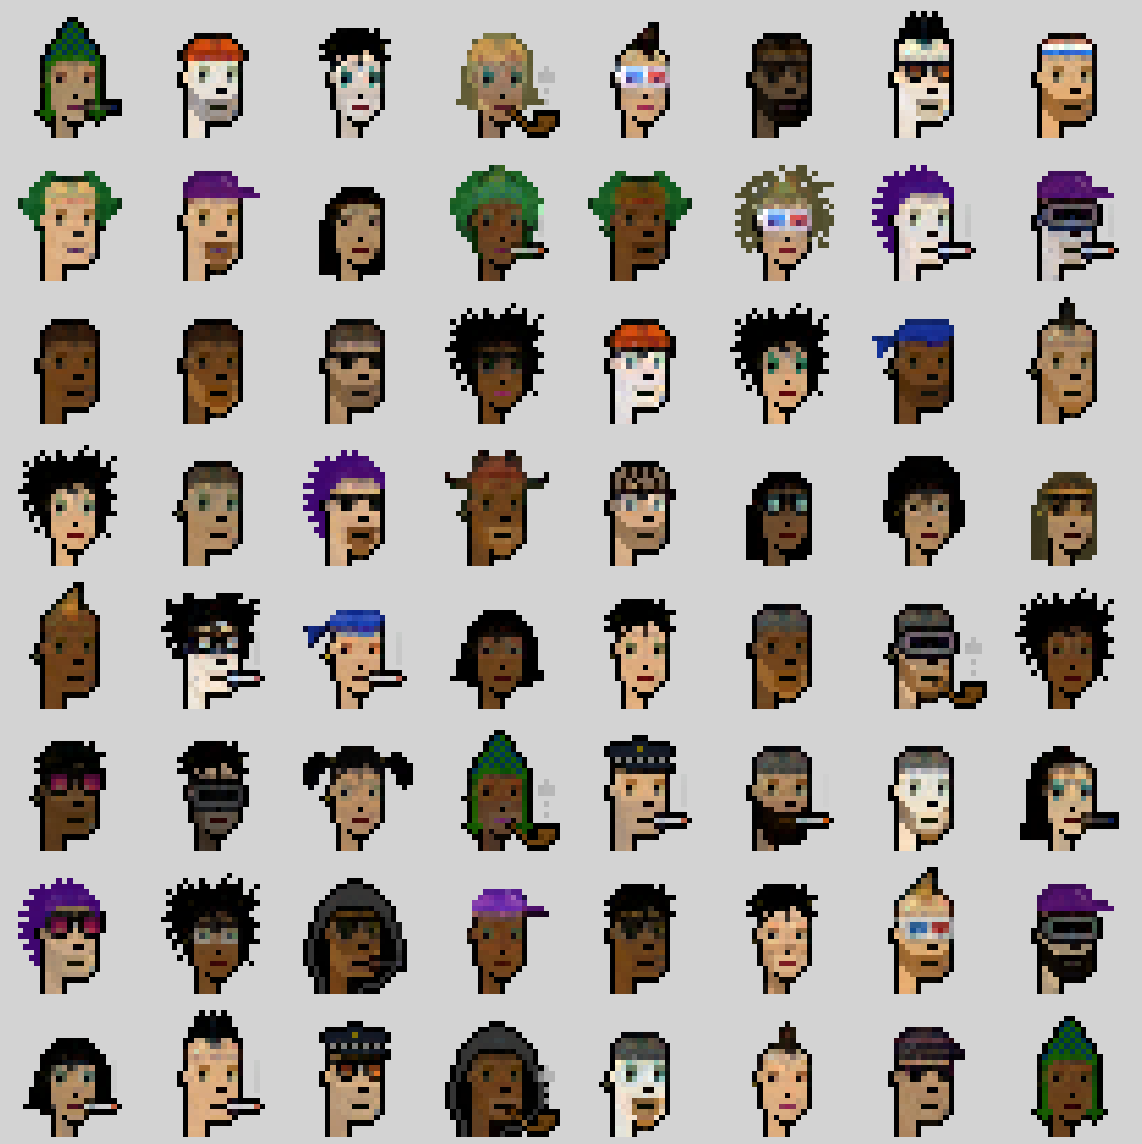

In [431]:
plotimgs(faces_reconstructed, 8, filename="faces_reconstructed.png")  #Plotting

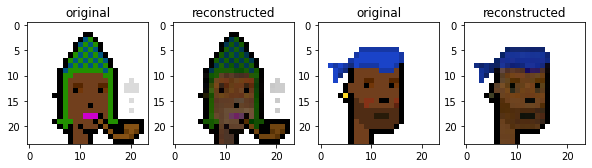

In [439]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
fig.set_figheight(10)
fig.set_figwidth(10)
ax1.set_title("original")
ax2.set_title("reconstructed")
ax3.set_title("original")
ax4.set_title("reconstructed")
ax1.imshow(faces[:,:,:,43])
ax2.imshow(faces_reconstructed[:,:,:,43])
ax3.imshow(faces[:,:,:,22])
ax4.imshow(faces_reconstructed[:,:,:,22])
plt.show()

The reconstructions are fairly good in the sense that you can recognize the faces and get a grip on what features the original cryptopunks inhabit. Their eyes, mouth, nose and other common features are more or less not disturbed. Since the opacity channel is added back into the WH we can now also separate the black pixels from the background. There also doesn't seem to be any to little color disturbance in places that are supposed to be completely transparent (i.e. pixels outside the outline, outside accessories, corners etc). 

Even though we can recognize the CryptoPunks, there are several factors that have changed while going through the NMF and all features of the dataset are not equally well reconstructed. First of all, some of the features have changed colors completely. This includes lipstick that have gone from pink to dark purple (as the example image to the left above shows). We can see that the green hat is much more vague, and the eyebrows have almost disappeared. Minor details have completely vanished for certain CryptoPunks. This includes details such as red cheeks and ear rings (which we can see for the man with the blue hat). 

This is likely because it's easier for our NMF to reconstruct features that are both common and have a certain size. If the feature appears rarely NMF will fail to generalize it and thereby not be able to reconstruct it well. We see that this happends to the grey cigarette with the blue tip. Since this feature dont appear to often, is worse reconstructed than the white cigarettes with the orange tip. It's also harder to recognize the pattern of small features which explains why a lot of the yellow ear ring has disappeared. 

As mentioned above, we cut all values that grew larger than one and set them to be equal to one. This will affect the color values as the relationship between certain color channels will be changed. It can have affected the CryptoPunk to become more gray-like as gray is present when the color values are more or less the same for all three channels. Cutting values that have become too high can equalize the numbers and therefore have such an effect in certain places.

We can also note how there's more variation in color in areas that before the NMF were identical in shade. Specifically, the contrast in the faces of the CryptoPunk have changed. Since we’re looking at a reconstruction of the images it's expected that the images are not perfect. If we increase our value for $d$ we’ll get better results. We will soon demonstrate this.





But before moving on we would like to see what would happen if we change the weightning of the features, in other words change H. We can do that by swithching out $H -> H^T$ and see how this affects the reconstructed images. 

In [417]:
#switching out H with H.T
H_T = H.T
H_T = H_T.reshape(H.shape)
WH_T2 = np.dot(W, H_T)
WH_T2 = WH_T2.reshape(24, 24, 3, 500)  #Reshaping

#reconstructing images with H.T instead of H
faces_reconstructed_T2 = np.concatenate((WH_T2, faces_opacity), axis=2) 
faces_reconstructed_T2[faces_reconstructed_T2>1]=1 

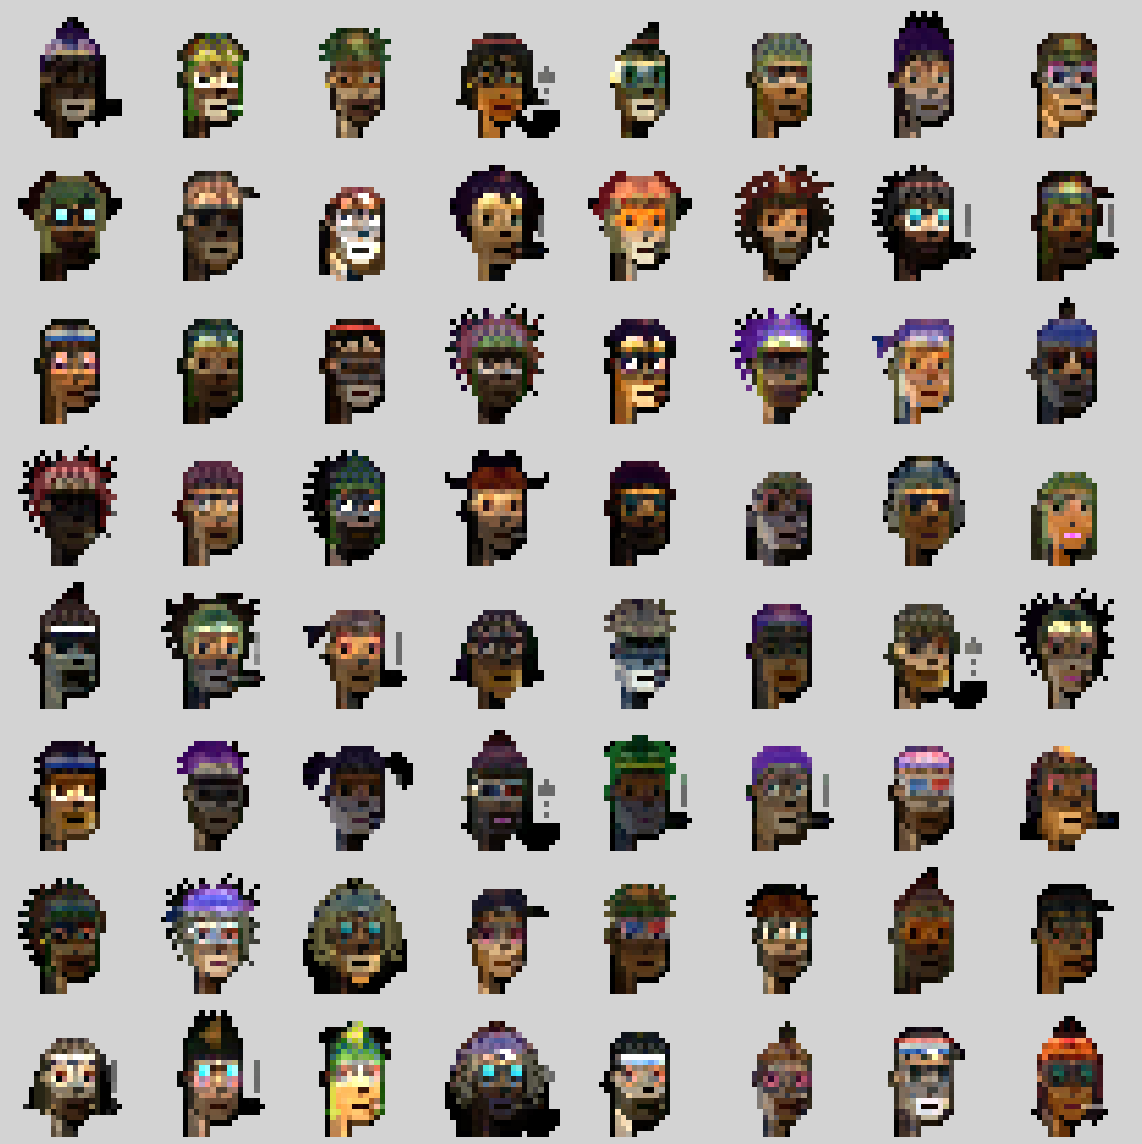

In [646]:
plotimgs(faces_reconstructed_T2,8)

 #### $H->H^T$

The images are much as expected. We see that the faces are still at the same places. Considering the fact that we messed up the H matrix, we will also mess up the weighting of each feature. This we can see in the plot. Many of the CryptoPunks have gotten several hats or glasses each, while some of them have gotten less than they should have. We can see that the structure of the original faces are still the same. This is because we have added the opacity channel, which means that the pixels are either transparent or not. Therefore the RGB-colors will only be visible on the pixels placed to the original outline of the CryptoPunk. With the normal reconstruction we did earlier, this was not an issue. But with wrong weightning, we can see that haircuts, hats and cigarettes are cut off. For other CryptoPunks we can see that some parts (on the edges) of the black background shape are not filled with any colors. This is because the features these cryptoPunks have been given are only centered at the middle of the faces. This shows that W contains the important features, while H contains the weighting of them. 

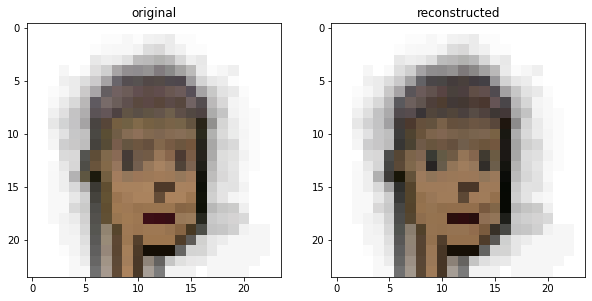

Number of opaque pixels for reconstructed images: 410
Rank of SVD reconstructed images 121
Number of opaque pixels original images: 410
Rank of SVD original images 385


In [648]:
mean_reconstructed = np.mean(faces_reconstructed, axis = 3)

faces_opacity_reconstructed = faces_reconstructed[:,:,3,:]
faces_rgb_reconstructed = faces_reconstructed[:,:,:3,:]
shape_reconstructed = faces_rgb_reconstructed.shape

# Clever reshape "trick". This is the matrix we will apply the NMF to
faces_reshaped_reconstructed = faces_rgb_reconstructed.reshape(np.prod(shape)//N, N)

#plt.figure(figsize = (20,5))
#plt.imshow(mean_reconstructed)
#plt.title('Mean cryptoPunk reconstructed')

fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figheight(10)
fig.set_figwidth(10)
ax1.set_title("original")
ax2.set_title("reconstructed")
ax1.imshow(mean)
ax2.imshow(mean_reconstructed)
plt.show()

print('Number of opaque pixels for reconstructed images:', findRank2(mean_reconstructed))
findRank(faces_reshaped_reconstructed, 'SVD reconstructed images')

print('Number of opaque pixels original images:', findRank2(mean))
findRank(faces_reshaped, 'SVD original images')


Since we now have reconstructed the images through the NMF we want to see how this affects the mean figure. The rank for our mean reconstructed CryptoPunk is far lower than for our original although the number of opaque pixels are still the same. This is because our CryptoPunk now has more colors that are alike. We can therefore assume that more of the vectors are linearly dependent. We also observe this in our image. The colors are also somewhat darker, and more gray like. This happens as we have lost certain information and have cutted of certain values, as discussed earlier. Taking all of this into account, it makes sense for the rank to have decreased. 

### Trying different values for N 

If we try to load fewer og more images we can expect the columns of W to look pretty different. We try with N = 64 and N = 1000 (compared to earlier where we used N = 500).

In [526]:
#Experimentation with different values of N 
#The same prosedure as before:

N_experiment1 = 64
N_experiment2 = 1000

faces_experiment1 = load_images(N_experiment1)
faces_experiment2 = load_images(N_experiment2)

choices_experiment1 = np.random.choice(faces_experiment1.shape[-1],N_experiment1, replace = False)
faces_experiment1 = faces_experiment1[:,:,:,choices_experiment1]

choices_experiment2 = np.random.choice(faces_experiment2.shape[-1],N_experiment2, replace = False)
faces_experiment2 = faces_experiment2[:,:,:,choices_experiment2]

faces_opacity_experiment1 = faces_experiment1[:,:,3,:]
faces_rgb_experiment1 = faces_experiment1[:,:,:3,:]
shape_experiment1 = faces_rgb_experiment1.shape

faces_opacity_experiment2 = faces_experiment2[:,:,3,:]
faces_rgb_experiment2 = faces_experiment2[:,:,:3,:]
shape_experiment2 = faces_rgb_experiment2.shape

faces_reshaped_experiment1 = faces_rgb_experiment1.reshape(np.prod(shape_experiment1)//N_experiment1, N_experiment1)
faces_reshaped_experiment2 = faces_rgb_experiment2.reshape(np.prod(shape_experiment2)//N_experiment2, N_experiment2)

In [527]:
#calculating the nmf for N = 64
W_experiment1, H_experiment1, normen_experiment1 = WH_NMF(faces_reshaped_experiment1, N_experiment1) 

In [528]:
#calculating the nmf for N = 1000
W_experiment2, H_experiment2, normen_experiment2 = WH_NMF(faces_reshaped_experiment2, N_experiment2) 

In [529]:
WH_experiment1 = np.dot(W_experiment1, H_experiment1)
WH_experiment1 = WH_experiment1.reshape(24, 24, 3, N_experiment1)  #Reshaping

WH_experiment2 = np.dot(W_experiment2, H_experiment2)
WH_experiment2 = WH_experiment2.reshape(24, 24, 3, N_experiment2)  #Reshaping

W_experiment1 = W_experiment1.reshape(24,24,3, N_experiment1)

W_experiment2 = W_experiment2.reshape(24,24,3, N_experiment2)

W_experiment1[W_experiment1>1]=1  #Clipping pixel values that are larger than 1, by setting them to 1. 
W_experiment2[W_experiment2>1]=1  #Clipping pixel values that are larger than 1, by setting them to 1. 

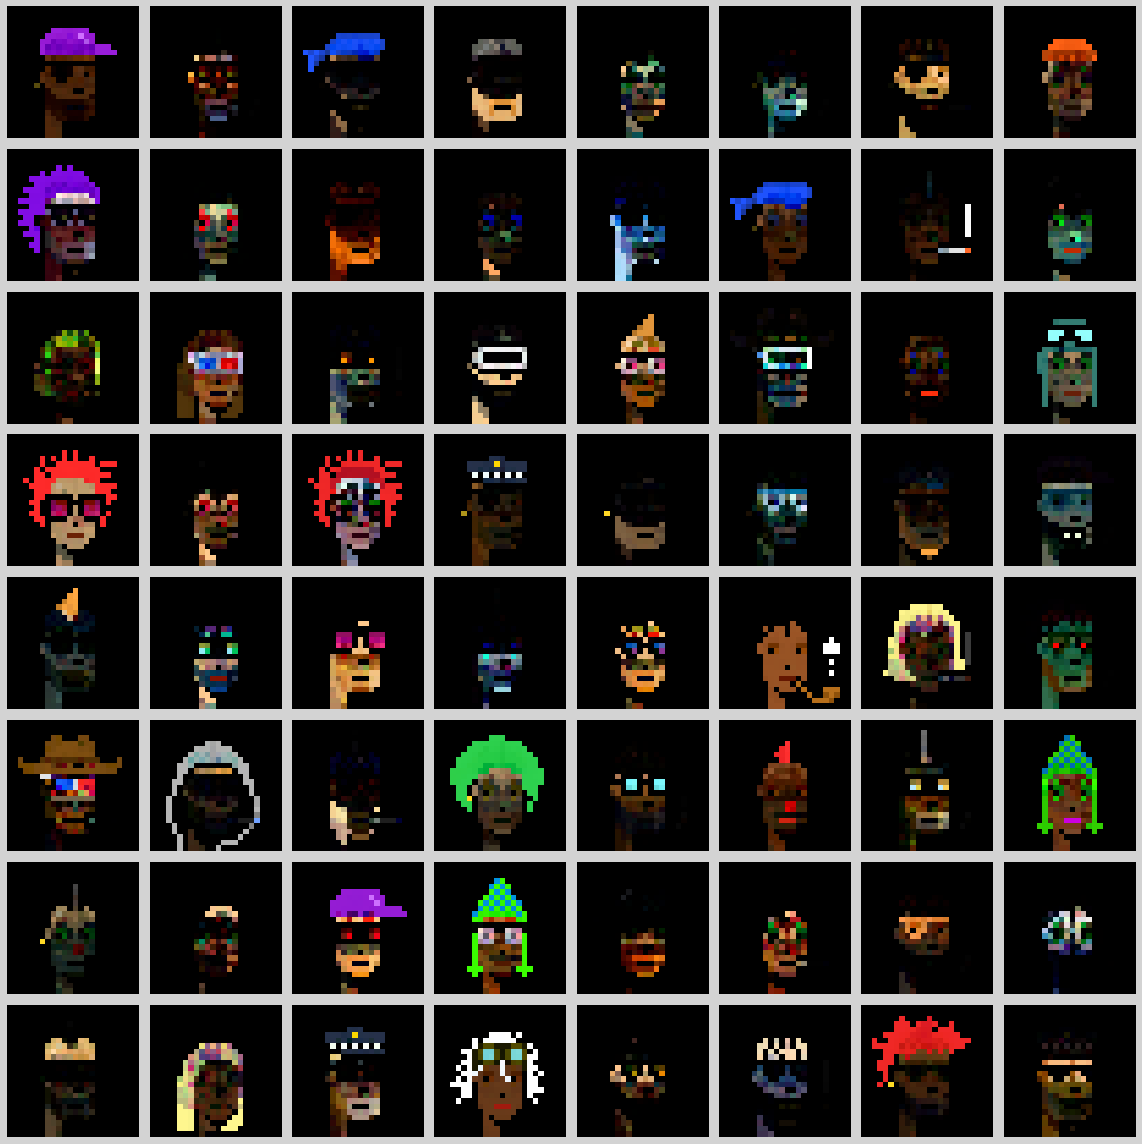

In [533]:
plotimgs(W_experiment1, nplot = 8, rescale = True) #Plotting columns of W

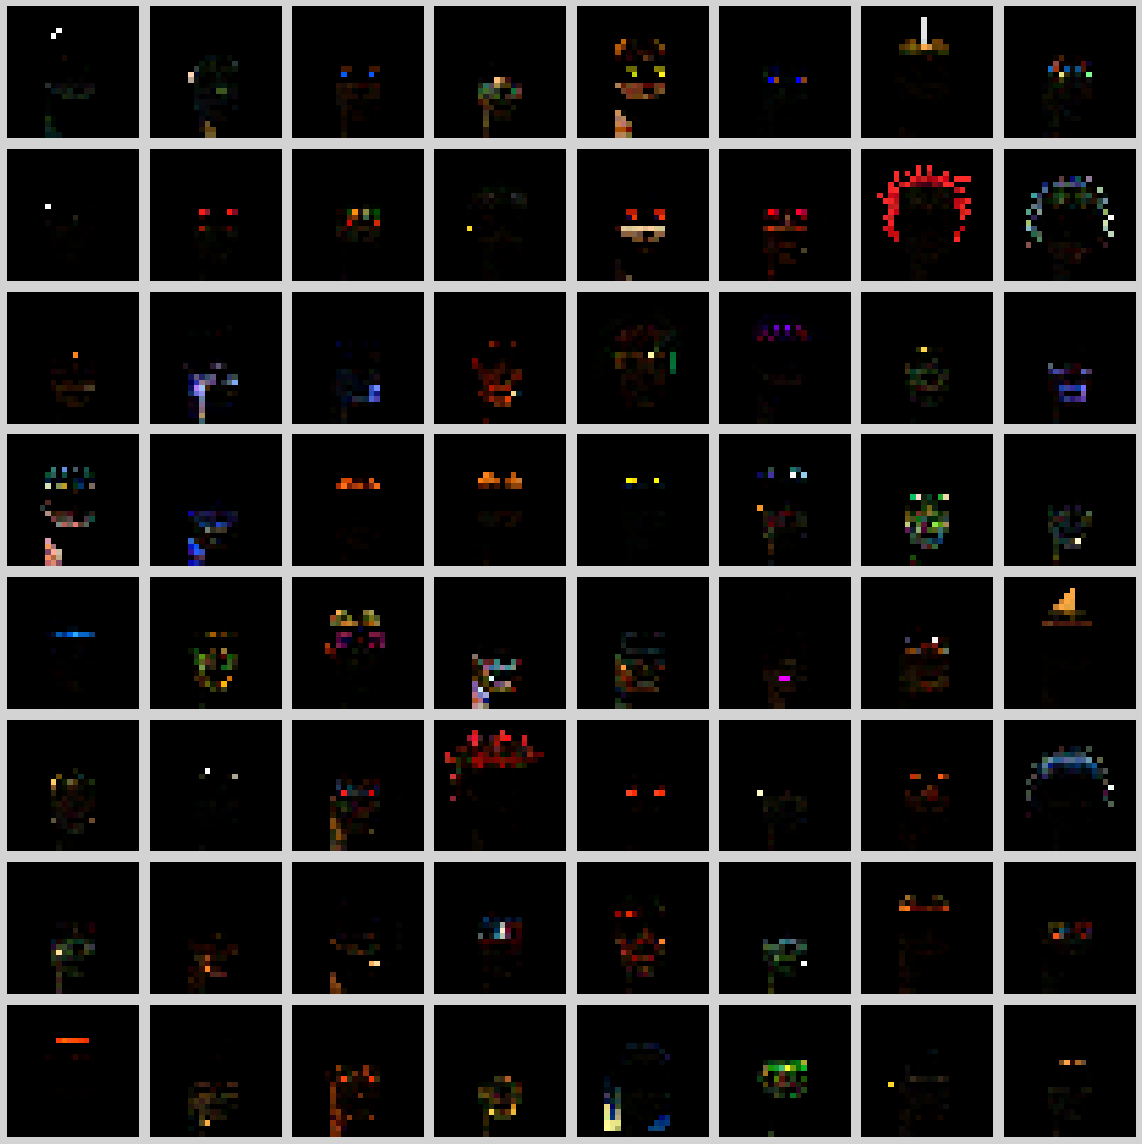

In [534]:
plotimgs(W_experiment2, nplot = 8, rescale = True, filename = "figur1") #Plotting columns of W

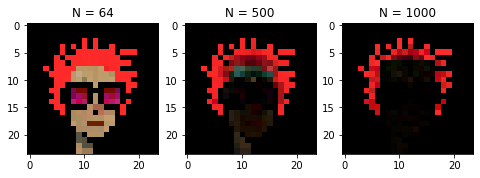

In [624]:
W_experiment1a = W_experiment1[:,:,:,24]
W_experiment1a[:,:,:3] = W_experiment1a[:,:,:3]/np.max(W_experiment1a[:,:,:3])

W_experiment2a = W_experiment2[:,:,:,14]
W_experiment2a[:,:,:3] = W_experiment2a[:,:,:3]/np.max(W_experiment2a[:,:,:3])

Wa = W[:,:,:,3]
Wa[:,:,:3]= Wa[:,:,:3]/np.max(Wa[:,:,:3])

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_figheight(8)
fig.set_figwidth(8)
ax1.set_title("N = 64")
ax2.set_title("N = 500")
ax3.set_title("N = 1000")
ax1.imshow(W_experiment1a)
ax2.imshow(Wa)
ax3.imshow(W_experiment2a)
plt.show()

The basis vectors we have plotted are really different for N = 64, N = 500 and N = 1000. Generally we can see that the columns of W with d = 64 looks more like a complete cryptoPunk than a feature. The image carry less independent information than for bigger values of N. Since we have loaded such few images, it will be difficult to separate the features. For example, if there are only a few cryptoPunks with red hair, and some of them have the same sunglasses as well, the algorithm might think that sunglasses are part of the feature. Therefore they might be saved together. Since we only loaded 64 images, it will be random what features we encounter. As we increase N our method will be able to separate such features and therefore save them separately. This we can see for the image plotted above. For N = 1000 the hair is independent from any other feature. We only see a few very vague pixels. For N = 500 we see something in between.


We can notice that for N = 1000 there are so many cryptoPunks to analyze for the NMF, and therefore it will be able to store smaller features separately. It is difficult to say what features many of the images are trying to save. But considering the fact that we are able to seperate them this much, we would think that the reconstructions might be better. This is something we will test in a bit. 

### How does the $\lVert{A-WH}\rVert_F$ depend on number of iterations?

As we saw for the small matrices (A1-A4) the norm was lowest for biggest values of d (up to rank) and converged fastest for small values of d. Lets how such a big matrix will depend on d.

In [636]:
#values for d we will test
d1 = 16
d2 = 32
d3 = 64
d4 = 128

maxiter = np.linspace(1, 1000, 1000)
W3d1, H3d1, normd1 = WH_NMF(faces_reshaped, d1, δ, len(maxiter))
W4d1, H4d1, normd2 = WH_NMF(faces_reshaped, d2, δ, len(maxiter))
W3d2, H3d2, normd3 = WH_NMF(faces_reshaped, d3, δ, len(maxiter))
W3d2, H3d2, normd4 = WH_NMF(faces_reshaped, d4, δ, len(maxiter))


Before we take a look at the plot, it is worth noticing that the time increases linearly with d. 

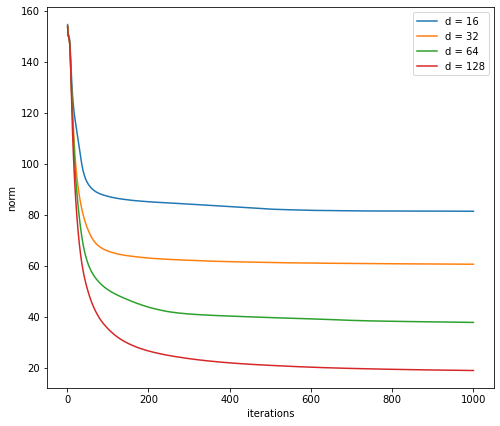

In [508]:
plt.figure(1)
fig = plt.gcf()
fig.set_size_inches(8, 7)
plt.plot(maxiter, normd1, label = 'd = 16')
plt.plot(maxiter, normd2, label = 'd = 32')
plt.plot(maxiter, normd3, label = 'd = 64')
plt.plot(maxiter, normd4, label = 'd = 128')
plt.xlabel('iterations')
plt.ylabel('norm')
plt.legend(loc = 'upper right')
plt.show()

As we would expect, the norm does shrink as the iterations increase. We can also observe that the results improve for a higher value of d. This is because W and H will obtain more of the original data which makes them able to better recreate the images. The norm thereby converges to a lower error value. We do however observe that the error converges faster for a smaller value of d.  As the line flattens out we can say that the three graphs have converged. This is intact with what we observed earlier as well. 
 
We do know that our rank is far higher than what we plotted for. Therefore we would expect that the highest value of d yields the best approximation to A. This is true for our graph. We can't say for sure that a higher value of d always will decrease the norm, but for values up until the rank of A we would expect this.


## How does the $\lVert{A-WH}\rVert_F$ depend on d for noisy images?

We apply the NMF on the image data for a wide range of d. We set the maximum number of iterations to 10.000, so that we are sure the NMF calculation has converged. 


In [649]:
dArr = np.array([2, 20, 60, 100, 140, 180, 220, 260, 300, 350, 400, 450, 500]) #Different values of d


def compareD(A, dVals, δ = 1e-9, maxiter = 1000, seed = 0):
    """
    input:
        A: (m,n) input array
        dVals: 1D array of integers, Number of components we want to decompose A into
        δ, float, small number for safe division
        maxiter: integer, maximum number of iterations
        seed: integer, random seed
    output:
        normArr: array with the norm for 
    """
    normArr = np.zeros(len(dVals))
    tArr = np.zeros(len(dVals))   
    #iterating through our d-values, to calculate the Frobenius norm of the resulting NMF matrix and original matrix
    for i in range(len(dVals)):
        t0 = time.time()
        W, H, norm = WH_NMF(A, dVals[i])
        t1 = time.time()
        normArr[i] = norm[-1]
        tArr[i] = t1-t0  #Calculating the run time for each evaluation
    return normArr, tArr


normArr, tArr = compareD(faces_rgb.reshape(np.prod(shape)//N, N), dArr)


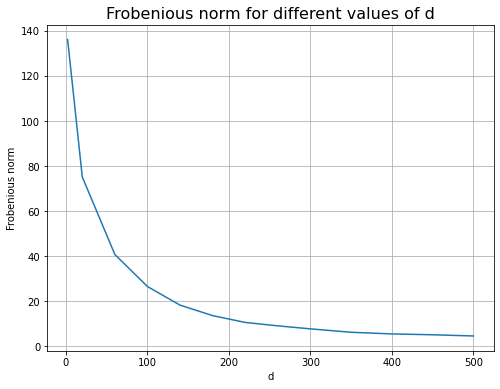

In [651]:
def plotNormbyD(x, y, time, title, ylabel, timelabel, fignumb, label1 = '', label = False):
    plt.figure(fignumb, (8, 6))
    plt.title(title, fontsize = 16)
    if label:
        plt.plot(x,y, label = label1)
    else: 
        plt.plot(x,y)
    plt.rcParams['figure.figsize'] = (3, 6)
    plt.grid()
    plt.xlabel(timelabel)
    plt.ylabel(ylabel)
plotNormbyD(dArr, normArr, tArr, 'Frobenious norm for different values of d', 'Frobenious norm', 'd', 1)

We plot the norm as a function of value $d$. The norm decreases with increasing $d$. It is expected that the norm decreases by greater values of $d$, because the NMF now stores more information from the original matrix. Nevertheless, this takes memory. The size of the matrix before the NMF is 1728x500 = 864000. 

In [647]:
header = ['d', 'Components of values (m*d + d*n)', 'Percentile of original matrix size, %', 'Memory saved, %']
row = [[16, 35648, 4.1, 95.9], [32, 71296, 8.3, 91.7],  [64, 142592, 16.5, 83.5], [128, 285184,  33.0, 67], [256, 570368, 66.0, 34], [512, 1140736, 132.0, -32]]
table = tabulate(row, header, tablefmt="fancy_grid")
print(table)

╒═════╤════════════════════════════════════╤═════════════════════════════════════════╤═══════════════════╕
│   d │   Components of values (m*d + d*n) │   Percentile of original matrix size, % │   Memory saved, % │
╞═════╪════════════════════════════════════╪═════════════════════════════════════════╪═══════════════════╡
│  16 │                              35648 │                                     4.1 │              95.9 │
├─────┼────────────────────────────────────┼─────────────────────────────────────────┼───────────────────┤
│  32 │                              71296 │                                     8.3 │              91.7 │
├─────┼────────────────────────────────────┼─────────────────────────────────────────┼───────────────────┤
│  64 │                             142592 │                                    16.5 │              83.5 │
├─────┼────────────────────────────────────┼─────────────────────────────────────────┼───────────────────┤
│ 128 │                             2

Number of $d$, sum of elements in $W$ and $H$, percentile of sum of elements in $W$ and $H$compared to original matrix, percentage of elements saved. 
We see that for greater values of $d$, the amount of elements saved decreases at the same rate that $d$ increases. For $d$=512, the sum of elements in $H$ and $W$ is bigger than elements in the original matrix. 

If the intention is to save space, it would be inappropriate to choose $d$ larger than 387. 
One would choose $d$ such that $1728\cdot d + d\cdot 500 < 1728 \cdot 500 $
$\frac{1728\cdot500}{1728+500} < 387.8$. 
We have also plotted the run time, which increases linearly with increasing $d$. 


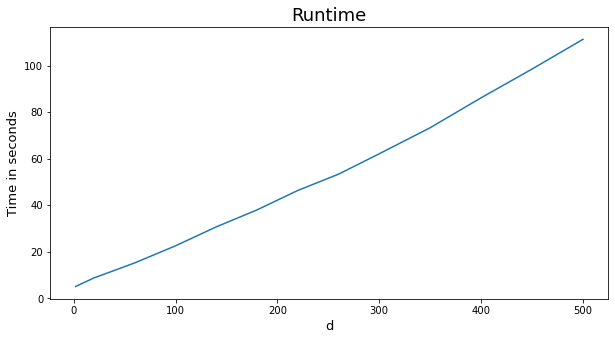

In [662]:
plt.figure(figsize=(10,5))
plt.title('Runtime', fontsize = 18)
plt.plot(dArr, tArr)
plt.xlabel('d', fontsize = 13)
plt.ylabel('Time in seconds', fontsize = 13)
plt.show()

Even though we’re mainly concerned about saving memory when it comes to image reconstruction, it's interesting to look at the method's runtime. If you were to transfer a great amount of data, one is often interested in both the amount of memory saved and the time it has taken to transfer the images, as well as the method's ability to reconstruct the images. Depending on how accurate one wants the reconstruction to be, it could be appropriate to choose $d$ around 200-400 in this case, as the norm does not decrease significantly for higher $d$, even if the ru time continues to increase linearly.

<h2> Adding noice </h2>

As introduced earlier on, we will now add noise to our images to see how the NMF operates when this is present. We will encounter two phenomena, namely over- and underfitting.
 
Underfitting appears when we choose a model complexity of the NMF that’s too low. The method will fail to reconstruct an image of good quality since we haven’t abstracted enough data from our original matrix. In this case the problem is oversimplified and can result in a huge error. Overfitting is when the model complexity of the NMF is set too high. Our matrices will obtain too much information and fail to generalize the most important structures. Instead, it will extract unwanted patterns such as noise as if the noise was an important part of our model structure. In a sense, the model will try to adapt too much to our data. In both cases our method will fail to generalize. The method then won’t perform well in the case of unseen data scenarios, defeating the model's purpose. 

We will see that our choise of $d$ will not be as simple as when we did not have noise on our data sets, where the norm decreased with increasing $d$. We will actually see that the norm decreases for increasing values of $d$, until we reach the optimal $d$, before the norm starts to increase again. 

We add noise by randomly adding standard normal distributed values to the pixels. This is the add_noise, function. The fact that the noise is standard normal and randomly distributed, means that it will not change the features of the image markably, and we will be able to reconstruct the images. We only add noise to the RGB-values, and then put back the opacity channel after adding the noise. 



In [272]:
def add_noise(imgs_reshaped, sigma = 0.1):
    """
    Adds gaussian noise to images as described in text.
    Note that imgs must be given as a (24*24*3, N) numpy array, i.e the reshaped images
    Input:
        imgs_reshaped: (1728,N) numpy array
        sigma: scalar, noise level
    Output:
        noisy_faces: (1728,N) numpy array containing noisy images
    """

    # Array that will store the rgb channels of the noisy images
    noisy_faces = np.copy(imgs_reshaped)

    # Number of noisy values we need
    nnzero = imgs_reshaped[np.nonzero(imgs_reshaped)].shape[0]

    # Sample noisy values and add noise
    noise = np.random.normal(0.0,1,nnzero)
    noisy_faces[np.nonzero(imgs_reshaped)] += sigma*noise

    # Clip to lie between 0 and 1 so that we can still interpret them as images
    noisy_faces = np.maximum(0.0,np.minimum(1.0, noisy_faces))

    return noisy_faces

41.94322888579333


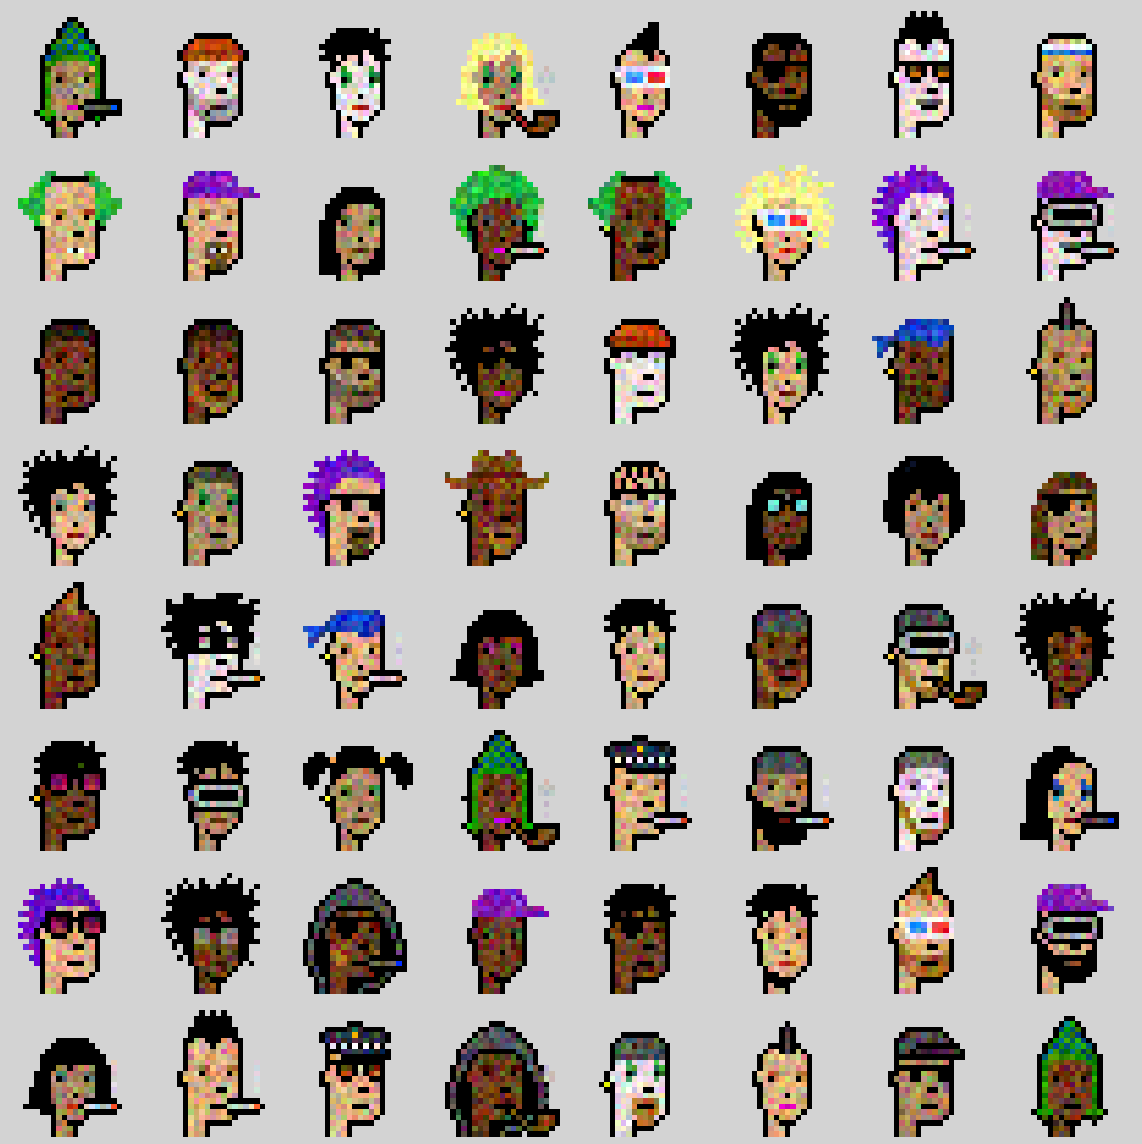

In [505]:
#Add noise with handed out code
faces_rgb = faces[:,:,:3,:]
faces_reshaped = faces_rgb.reshape(np.prod(shape)//N, N)
noisy_faces = add_noise(faces_reshaped)


# Calculate the error of the noisy images
noise_residual = np.linalg.norm(noisy_faces - faces_reshaped, 'fro')
print(noise_residual)   #What does this number mean?

# For plotting noisy images we add the opacity
noisy_faces_with_opacity = np.zeros(faces.shape)

#reshaping
noisy_faces = noisy_faces.reshape(faces_rgb.shape)


#put noisy_faces back together with opacity chanel
noisy_faces_with_opacity = np.concatenate((noisy_faces, faces_opacity), axis = 2)

plotimgs(noisy_faces_with_opacity, 8)

We start off by adding noise to the CryptoPunks and observe that they now are of lower quality. The norm is calculated to be approximately around 42. We would expect an error as we now have defected the images. The norm of the reconstructed CryptoPunks with d = 64 is about 40, which means that our CryptoPunks with noise hold about the same error as the reconstructed images from earlier. This gives us some insight to how defected the images have gotten by adding the noise. 

As we study the figures we observe a huge variation in color. They are much more disturbed. However, the colors haven't changed completely for certain features as they did for our reconstructed CryptoPunks earlier on. They do not miss certain features either, but they can still be hard to spot. The black pixels are still intact. This is because black is achieved by setting all color channels to 1. Since we clip values back to 1 after applying noise the black pixels won't be affected. 


## Denoising

We will now apply the NMF to the noisy images and study the result. As we have observed before, we will lose quite a few details when we fit the NMF to the images. It is therefore to be expected that we won't restore the original data perfectly, and instead lose some information (hopefully noise). 

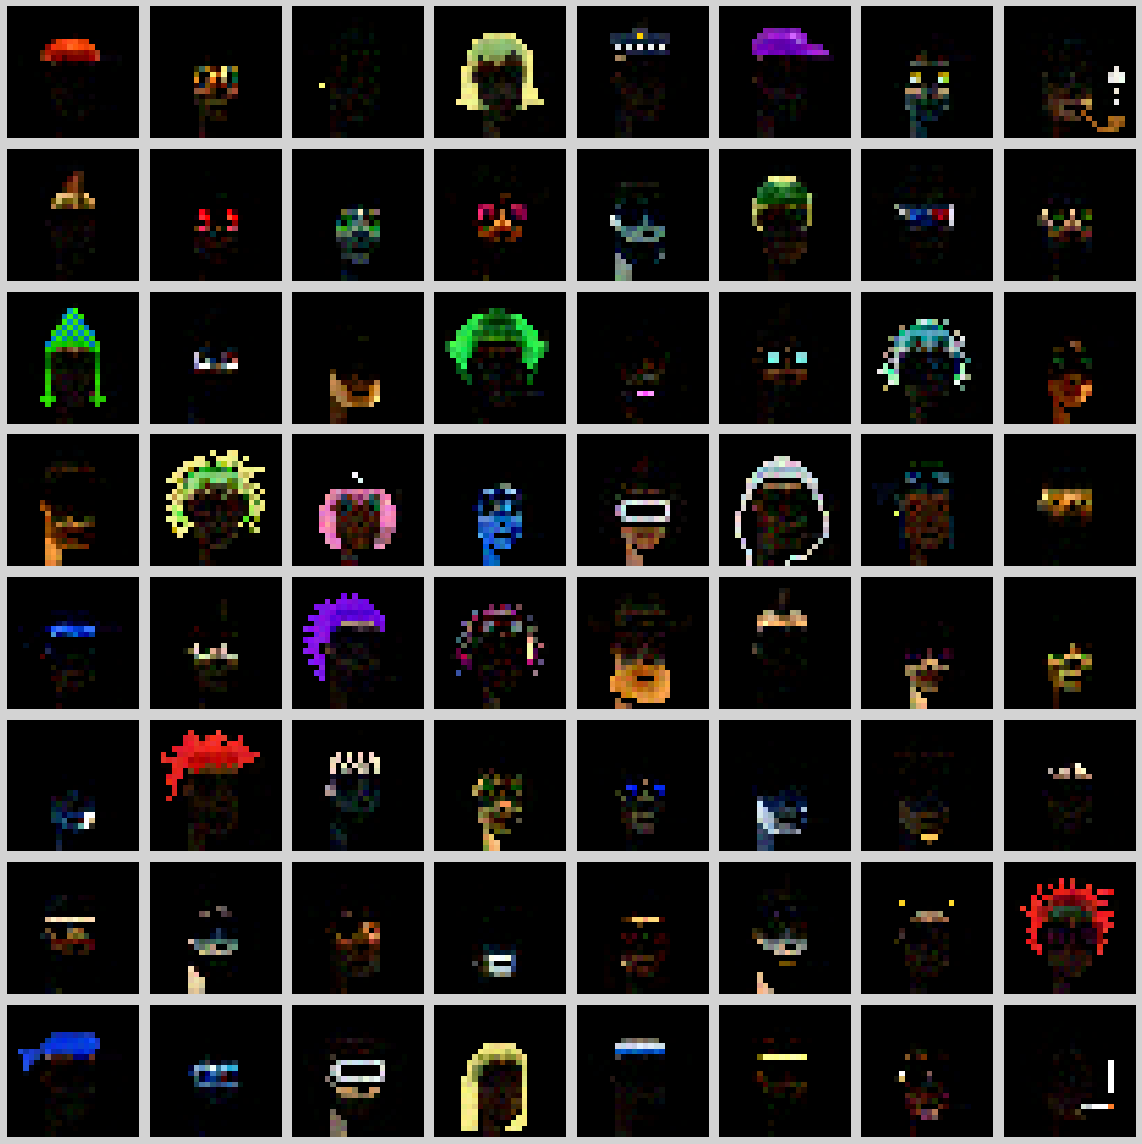

In [546]:
# Split the images into opacity and rgb channels
noisy_faces_opacity = noisy_faces_with_opacity[:,:,3,:]
noisy_faces_rgb = noisy_faces_with_opacity[:,:,:3,:]
shape_noisy = noisy_faces_rgb.shape

# Clever reshape "trick". This is the matrix we will apply the NMF to
noisy_faces_fit = noisy_faces_rgb.reshape(np.prod(shape_noisy)//N, N)

W_noisy, H_noisy, normen_noisy = WH_NMF(noisy_faces_fit, 64, seed = 1)  #Calculating the NMF of the 3 color channels using d = 64
W3, H3, norm3 = WH_NMF(faces_reshaped, 64, seed = 1)

W_noisy[W_noisy>1] = 1
W_noisy = W_noisy.reshape(24,24,3,64)

W3[W3>1] = 1
W3 = W3.reshape(24,24,3,64)
plotimgs(W_noisy, 8, rescale = True)

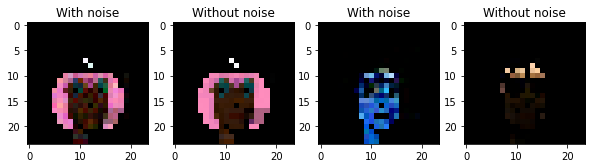

In [565]:
#rescale
W_noisya = W_noisy[:,:,:,26]
W_noisya[:,:,:3] = W_noisya[:,:,:3]/np.max(W_noisya[:,:,:3])
W3a = W3[:,:,:,26]
W3a[:,:,:3] = W3a[:,:,:3]/np.max(W3a[:,:,:3])
W_noisyb = W_noisy[:,:,:,27]
W_noisyb[:,:,:3] = W_noisyb[:,:,:3]/np.max(W_noisyb[:,:,:3])
W3b = W3[:,:,:,27]
W3b[:,:,:3] = W3b[:,:,:3]/np.max(W3b[:,:,:3])
#plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
fig.set_figheight(10)
fig.set_figwidth(10)
ax1.set_title("With noise")
ax2.set_title("Without noise")
ax3.set_title("With noise")
ax4.set_title("Without noise")
ax1.imshow(W_noisya)
ax2.imshow(W3a)
ax3.imshow(W_noisyb)
ax4.imshow(W3b)
plt.show()

What we see is that the NMF in some way improves our image and reduces the noise from before the reconstruction. 

First we would like to look at the difference between $W$ and $W_{noisy}$. The images look pretty similar at first glance, but $W_{noisy}$ has some defects. There are generally more colors and bigger contrasts on $W_{noisy}$ than on W. This is as expected. If we interpret each column of W to be a mean of all the noisy images with the same feature, we know that there will be a reduction of the variance, which is noise in our case. Therefore we can already now start to think that the noise will be less on the reconstructed images, than on the original noisy images. 

If we compare the woman with the pink hair we can see that the skin is much clearer in the picture without noise. This is as expected, and it's simply just because we have added noise. The main features are still the same, we can see both of them have green eyeshadow and a dark brown skin tone. This pink hair is pretty common, and therefore the NMF is able to recognize it, and make a good reconstruction. Other features that are more uncommon, and will not be reconstructed in such a good way.

The example to the right shows two images that are supposed to show approximately the same feature. They do not look very much alike. Without noise it's just supposed to be the structure of a forehead, and some black shades. With the noise the NMF-fit probably has problems recognizing this feature, and the result is a blue man. For the noisy images, the blue man is still representative in many images, and will therefore be saved as a feature. This example shows how the noise will affect the NMF application. 


### Noisy reconstruction

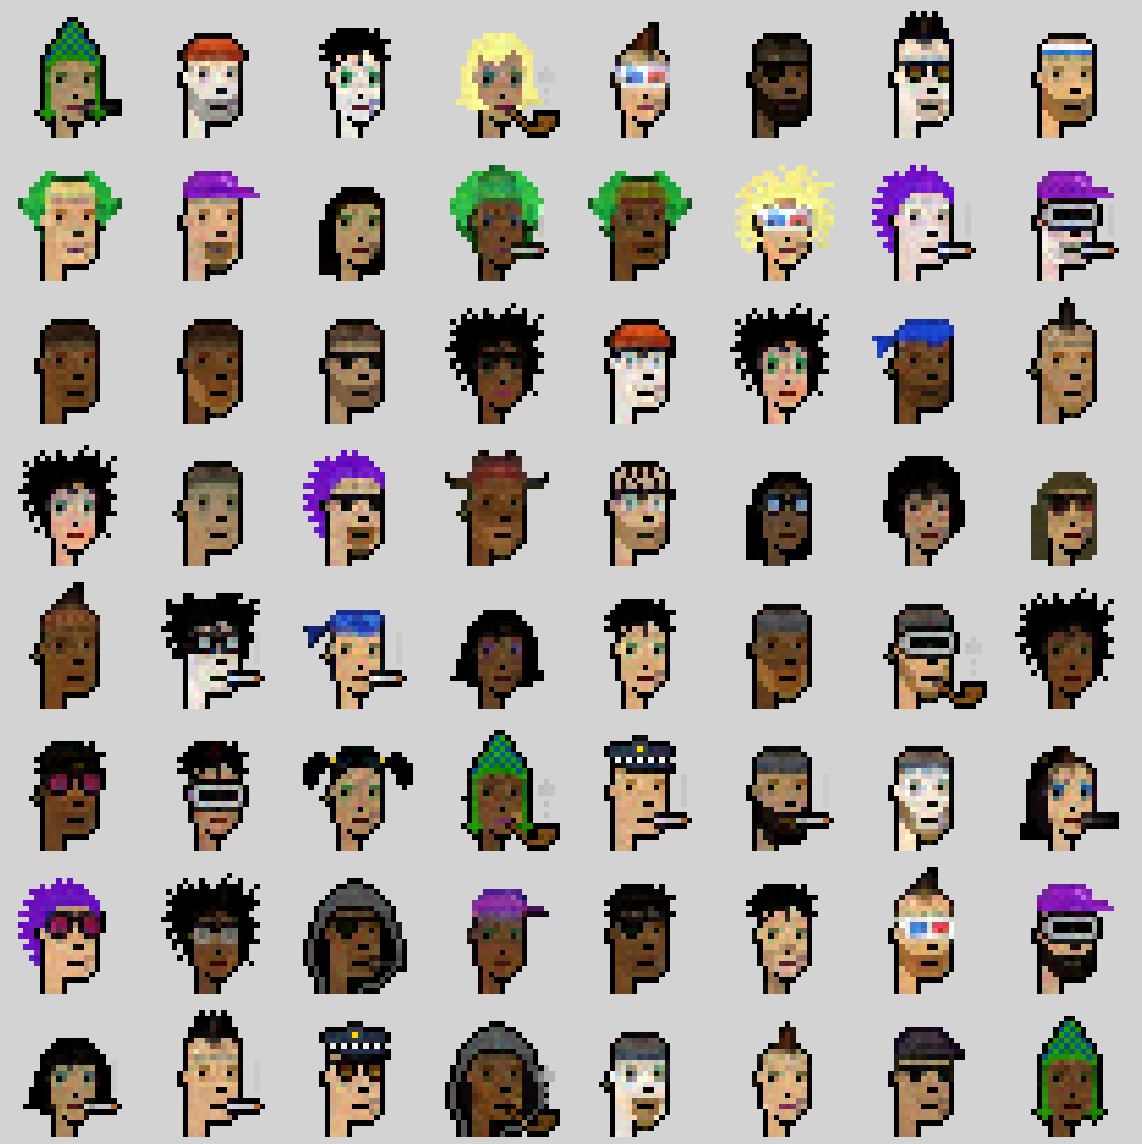

In [554]:
#Reshaping
WH_noisy = np.dot(W_noisy, H_noisy)
noisy_faces_reshaped = WH_noisy.reshape(24, 24, 3, 500)  #Reshaping

a = noisy_faces_opacity.reshape(24, 24, 1, 500)  #To concatenate we need our arrays to have the same size, except the axis we will concatenate (axis = 2)
b = noisy_faces_reshaped

noisy_faces_reconstructed = np.concatenate((b, a), axis=2)   #Reconstructing our values by adding the opacity values as the last element behind our RGB values. This is the third axis (index 2) of our array. 

noisy_faces_reconstructed[noisy_faces_reconstructed>1]=1  #Clipping pixel values that are larger than 1, by setting them to 1. 

WH3 = np.dot(W3, H3)
W3_r = WH3.reshape(24, 24, 3, 500)  #Reshaping

a3 = faces_opacity.reshape(24, 24, 1, 500)  #To concatenate we need our arrays to have the same size, except the axis we will concatenate (axis = 2)
b3 = W3_r

W3_reconstructed = np.concatenate((b3, a3), axis=2)   #Reconstructing our values by adding the opacity values as the last element behind our RGB values. This is the third axis (index 2) of our array. 

W3_reconstructed[W3_reconstructed>1]=1  #Clipping pixel values that are larger than 1, by setting them to 1. 

plotimgs(noisy_faces_reconstructed, 8, filename="noisy_faces_reconstructed.png")  #Plotting

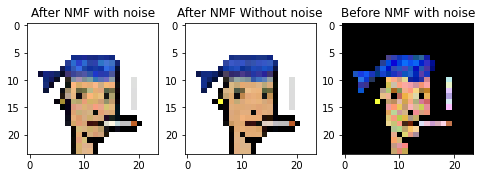

In [561]:
#rescale
W_noisya_r = noisy_faces_reconstructed[:,:,:,34]
W_noisya_r[:,:,:3] = W_noisya_r[:,:,:3]/np.max(W_noisya_r[:,:,:3])
W3a_r = W3_reconstructed[:,:,:,34]
W3a_r[:,:,:3] = W3a_r[:,:,:3]/np.max(W3a_r[:,:,:3])
#plot
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_figheight(8)
fig.set_figwidth(8)
ax1.set_title("After NMF with noise")
ax2.set_title("After NMF Without noise")
ax3.set_title("Before NMF with noise")
ax1.imshow(W_noisya_r)
ax2.imshow(W3a_r)
ax3.imshow(noisy_faces[:,:,:,34])
plt.show()

We can see that the reconstruction of the noisy images is pretty good. We have managed to get rid of much noise. The reason for this is that when we fit a NMF, we will lose some information, and therefore lose some details. In this case we benefit from losing some of the details because some of the details are noise. The signal of the original images will be more important than the noise. This is due to our low dimensional representation of the data. But we will also lose some important information from the original images, and therefore the reconstruction will not be as good  as the ones without noise. 

We can compare the man with the blue hat after NMF (with and without noise). All of the most important features, such as the cigarette and the blue hat are in both images. The difference between them is mainly the skin color. As expected the skin is much more clear without noise. We can also see that the yellow earring has become more vague. 

Still we can say that the image with noise after NMF, looks more like the image without noise (after NMF) than the image before NMF (with noise). Therefore we can safely say that the NMF has helped us get rid of unwanted noise. 



### Reconstructed noisy images compared to the originals

To finish off we again want to see how the norm varies as a function of d. In particular, we will compare the reconstruction of the noisy images with the original images without noise for different values of d. How will under- and overfitting affect the results?

In [616]:
dArr_noisy = np.array([2, 20, 60, 100, 140, 180, 220, 260, 300, 400, 512])

def compareD_noisy(A, A_noisy, dVals, δ = 1e-9, maxiter = 1000, seed = 0):
    """
    input:
        A: (m,n) input array. The original matrix, fitted
        A_noisy: (m,n) input array. The original matrix with noise, fitted
        dVals: 1D array of integers, Number of components we want to decompose A into
        δ, float, small number for safe division
        maxiter: integer, maximum number of iterations
        seed: integer, random seed
    output:
        normArr: array with the norm for
        tArr: array with run time values
    """
    normArr = np.zeros(len(dVals))
    tArr = np.zeros(len(dVals))   
    #iterating through our d-values, to calculate the Frobenius norm of the resulting NMF matrix and original matrix
    for i in range(len(dVals)):
        t0 = time.time()
        W, H, norm = WH_NMF(A_noisy, dVals[i])
        t1 = time.time()
        normArr[i] = np.linalg.norm(A - np.dot(W,H), 'fro')
        tArr[i] = t1-t0  #Calculating the run time for each evaluation
    return normArr, tArr

normArr_noisy, tArr_noisy = compareD_noisy(faces_reshaped, noisy_faces_fit, dArr_noisy)

The norm is lowest at d =  180 for images with noise


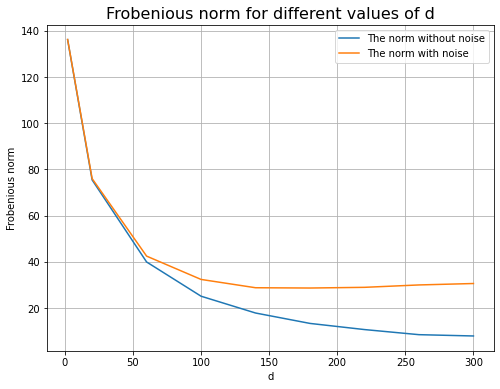

In [580]:
plotNormbyD(dArr, normArr, tArr, 'Frobenious norm for different values of d', 'Frobenious norm', 'd', 1, 'The norm without noise', label = True)
plt.plot(dArr, normArr_noisy, label = 'The norm with noise')
plt.legend()
lowest_index = (np.argmin(normArr_noisy))
print("The norm is lowest at d = ",dArr_noisy[lowest_index], "for images with noise")
plt.show()

We now plot the norm for both reconstructions (with and without noise). The plot for the reconstruction error for the noisy images is between “U-shaped” and “L-shaped”. This is because as we have seen before the error will be larger for smaller values of d. We don't manage to capture all the important details and lose much important information with such small matrices. We’ve then obtained underfitting as described earlier. This occurs for both graphs. With such a small value for d, the noise doesn't affect the reconstruction too much as we either way get a huge error.

As we increase d we can see that the difference between the two errors grows. The reconstruction without noise has an error that constantly decreases as d increases. The reconstruction error for the matrix that contains noise on the other hand has an interesting turning point. When d equals around 180 we observe that an increase in d will also increase our reconstruction error slightly. This is where we obtain overfitting and our NMF starts to learn more noise and less of the structure than we would prefer. Right before this happens is where the optimized value for d is, ergo our turning point. We can say that an optimal value for d lies around 180, with N = 500.

We can also notice that we will need at least d = 70 before we can get rid of any noise (because the noisy images themselves had a norm about 40). With a smaller value for d, we will not get better images by running them through the NMF. 

We can see that the norm does not increase much for bigger values of d, and this is because we use non-negative matrices. They force the weights to have positive magnitudes and prevents them from getting to big in magnitude. This help prevent overfitting. We also know that NMF is unsupervised. This means that the model is fitted without knowledge of the original data (without noise). This makes the model less effective than a supervised methos. But on the other hand, the model is less prone to overfitting. Since we here have both the original data, and the noisy data, it could have been more effective to use a supervised method. 

### Different values of N

Earlier we experimented a bit with different values for N. We used N = 64 and N = 1000. It can be interesting to see how the norm will either increase or decrease as we change N. To make it comparable, we have to look at the norm per image, and not the total norm. Therefore we divide the norm-array by the number of images before plotting it.


In [596]:
#Redoing everyting for different values of N:
noisy_faces_ex1 = add_noise(faces_reshaped_experiment1)
noisy_faces_with_opacity_ex1  = np.zeros(faces_experiment1.shape)
noisy_faces_ex1  = noisy_faces_ex1.reshape(faces_rgb_experiment1.shape)
faces_opacity_experiment1 = faces_opacity_experiment1.reshape(24,24,1,64)
noisy_faces_with_opacity_ex1  = np.concatenate((noisy_faces_ex1 , faces_opacity_experiment1), axis = 2)
noisy_faces_opacity_ex1  = noisy_faces_with_opacity_ex1 [:,:,3,:]
noisy_faces_rgb_ex1  = noisy_faces_with_opacity_ex1 [:,:,:3,:]
shape_noisy_ex1  = noisy_faces_rgb_ex1 .shape
noisy_faces_fit_ex1  = noisy_faces_rgb_ex1.reshape(np.prod(shape_noisy_ex1)//64, 64)

noisy_faces_ex2 = add_noise(faces_reshaped_experiment2)
noisy_faces_with_opacity_ex2  = np.zeros(faces_experiment2.shape)
noisy_faces_ex2  = noisy_faces_ex2.reshape(faces_rgb_experiment2.shape)
faces_opacity_experiment2 = faces_opacity_experiment2.reshape(24,24,1,1000)
noisy_faces_with_opacity_ex2  = np.concatenate((noisy_faces_ex2 , faces_opacity_experiment2), axis = 2)
noisy_faces_opacity_ex2  = noisy_faces_with_opacity_ex2 [:,:,3,:]
noisy_faces_rgb_ex2  = noisy_faces_with_opacity_ex2 [:,:,:3,:]
shape_noisy_ex2  = noisy_faces_rgb_ex2 .shape
noisy_faces_fit_ex2  = noisy_faces_rgb_ex2.reshape(np.prod(shape_noisy_ex2)//1000, 1000)

In [617]:
#Calculating the NMF for experiment 1
dArr_noisy = np.array([2, 20, 60, 100, 140, 180, 220, 260, 300])

normArr_noisy_ex1, tArr_noisy_ex1 = compareD_noisy(faces_reshaped_experiment1, noisy_faces_fit_ex1, dArr_noisy)

In [618]:
#Calculating the NMF for experiment 2

normArr_noisy_ex2, tArr_noisy_ex2 = compareD_noisy(faces_reshaped_experiment2, noisy_faces_fit_ex2, dArr_noisy)

The norm is lowest at d =  60 for images with noise and N = 64
The norm is lowest at d =  180 for images with noise and N = 500
The norm is lowest at d =  180 for images with noise and N = 1000
Running time N = 64:  15.007410287857056
Running time N = 500:  60.50987696647644
Running time N = 1000:  115.63133406639099


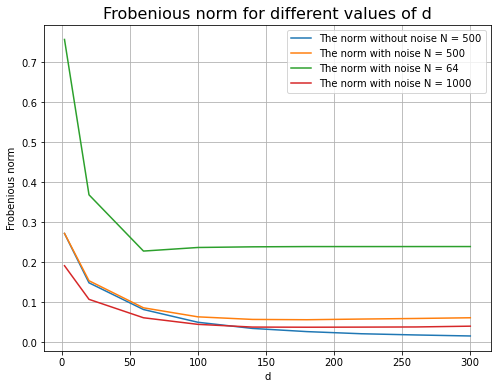

In [643]:
plotNormbyD(dArr, normArr/500, tArr, 'Frobenious norm for different values of d', 'Frobenious norm', 'd', 1, 'The norm without noise N = 500', label = True)
plt.plot(dArr, normArr_noisy/500, label = 'The norm with noise N = 500')
plt.plot(dArr, normArr_noisy_ex1/64, label = 'The norm with noise N = 64')
plt.plot(dArr, normArr_noisy_ex2/1000, label = 'The norm with noise N = 1000')
plt.legend()
lowest_index = (np.argmin(normArr_noisy))

lowest_index1 = (np.argmin(normArr_noisy_ex1))
print("The norm is lowest at d = ",dArr_noisy[lowest_index1], "for images with noise and N = 64")
lowest_index = (np.argmin(normArr_noisy))
print("The norm is lowest at d = ",dArr_noisy[lowest_index], "for images with noise and N = 500")
lowest_index2 = (np.argmin(normArr_noisy_ex2))
print("The norm is lowest at d = ",dArr_noisy[lowest_index2], "for images with noise and N = 1000")

print("Running time N = 64: ", tArr_noisy_ex1[-1])
print("Running time N = 500: ", tArr_noisy[-1])
print("Running time N = 1000: ", tArr_noisy_ex2[-1])

If we compare the noisy images, it is clear that the norm per image is smallest for N = 1000. Nevertheless it is not a huge difference between N = 500 and N = 1000. This means that it would probably be better to use N = 500, since the running time for N = 1000 is almost twice as big. This depends on what's more important; memory and running time or to get the best reconstructions. However, for N = 64, the norm quickly converges. This does not mean that it is better, because we can see that the norm is much bigger than for the others. We also see that the "optimal" d is much smaller for N = 64 than the others.

All of this is intact with what we discussed earlier. We compared the basis vectors for the three different N. Here we discovered that for a smaller N, the columns of W contained less independent information, which we assumed would lead to poorer reconstructions. Here we can confirm that this is the case.

It is also interesting to see that with N=1000 and noise, we get a better reconstruction than for N=500 without noise. when we take in as many as 1000 photos, there are many more photos to generalize from, which means that special features will not be considered general facial features. This is true for $d$ up to approximately 130.


### Conclusion
NMF has proven to be a useful method to apply in order to obtain size reduction and noise reduction, and it  yields usable results. It’s clear that the method heavily depends on what model complexity we choose to use. For cases without noise an increase in d will yield better results up until the rank of our original matrix and can both increase and decrease further. When noise is present, we’ll be able to calculate an optimal value for d for in which our matrix minimizes the error. This is done by avoiding over- and underfitting. The reconstructions improves or remains same as we increase the number of iterations. 

In other words we see that if the NMF is used in the right way (with a proper d and N) we can use it to our advantage. We now know that it is not possible to get a perfect reconstruction of images with noise, but we are able to decrease the norm considerably. An advantage of using NMF is that images are non-negative, so it is easy to decompose them into non-negative vectors. A disadvantage of NMF is that it is unsupervised, which means it is less effective. 

The non-negative constraint is also a very important advantage when it comes to image processing. Since the most common way to store image data is as data with only positive values, it would be impossible to reconstruct readable image data without the non-negative constraint. We have proven that our algorithm guarantees non-negativity. In some cases this can be a disadvantage, as it makes it impossible to use our algorithm on problems that do not have non-negative data values.

A disadvantage to the algorithm is that it does not have a specific global minima. The initialization of $W_0, H_0$ is completely random, which means that the same parameter values will give different runs each time. We have clearly seen this when we compared the norm for different initialization values; $W$ and $H$ converged to a local minimum value. This wont not necessarily be a problem but it provides less predictability. 

In today’s world the available data rapidly increases and the demand for data science skills is growing. Machine learning isn’t an easy thing, but this project gives us insight into the importance of the field. It’ll be interesting to see how the field continues to evolve in the years to come.




### Sources

- ("Matrix norm", 06.04.22), https://en.wikipedia.org/wiki/Matrix_norm
- ("How to Reduce Overfitting Using Weight Constraints in Keras", 26.11.18) https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-neural-networks-with-weight-constraints-in-keras/
- ("Algorithms, Initializations, and Convergence", read 08.04.2022)http://www.dm.unibo.it/~simoncin/NMFInitAlgConv.pdf
